# **DLAI PROJECT Team 4**



# Optional B: GAN
Steps:


1. Implement a generator and discriminator based con deconvolutions and convolutions respectively.

2. Train the GAN on MNIST.

3. Generate samples with the generator and show them.

**EXERCISE 1** Implement a generator and discriminator based con deconvolutions and convolutions respectively.

In [0]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

import torch
import random
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils
from IPython.display import display
from PIL import Image
import numpy as np
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


SOME UTILS WITH MINOR IMPORTANCE:

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size, 100).normal_()

def rand_label():
    FT = torch.cuda.LongTensor
    return Variable(FT(np.random.randint(0, 10, batch_size)))


  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)
  
def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    img = img.cpu().float()    
    img = (img*std+mean)*255

    image_numpy = img.detach().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

Import DATASET

In [0]:
def mnist():
    tf = transforms.Compose(
        [
            transforms.Resize(32, interpolation=0),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (.5,))
        ])
    return datasets.MNIST(root='./data/', train=True, transform=tf, download=True)

Lets create a DataLoader for the Mnist Dataset

In [0]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist(), batch_size=batch_size, shuffle=True)

Now, lets define the GENERATOR

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(10, 10)
        self._fc = torch.nn.Linear(100, 1024*4*4)
        self.Linear = torch.nn.Linear(100*110, 100*100)

        self._conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self._conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self._conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=1, kernel_size=4, stride=2, padding=1, bias=False),
            torch.nn.Tanh()
        )

    def forward(self, x, labels3):
        x = torch.cat((self.label_embed(labels3), x), -1)
        x = x.view(-1, 100*110)
        x=self.Linear(x)
        x = x.view(100, 100)
        x = self._fc(x)        
        x = self._conv1(x.view(x.shape[0], 1024, 4, 4))
        x = self._conv2(x)
        x = self._conv3(x)
        return x


And now the DISCRIMINATOR

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.label_embed_d = nn.Embedding(10, 10)
        self.Pol = nn.MaxPool1d(1,1)

        self._conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self._conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self._fc = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels2):
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)

        return self._fc(x.view(-1, 512*4*4))

Lets create the MODEL

In [0]:
class Model:

    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    def generate_samples(self, batch_size):
        z = norm_noise(batch_size)
        gen_label = rand_label()
        fake_samples = self._generator(z,gen_label)
        return fake_samples, gen_label
    
    def step_optimization(self, real_samples, labels1):
        fake_samples, gen_label = self.generate_samples(real_samples.size(0))
        
        loss_g = self._step_opt_g(fake_samples, gen_label)
        
        loss_d = self._step_opt_d(real_samples, fake_samples.detach(), gen_label, labels1)
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples, gen_label):
        self._opt_g.zero_grad()
        estim_fake = self._discriminator(fake_samples, gen_label)
        loss = self._criterion(estim_fake, self._label_real)
        loss.backward()
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples, gen_label, labels1):
        self._opt_d.zero_grad()

        estim_real = self._discriminator(real_samples,labels1)
        loss_real = self._criterion(estim_real, self._label_real)

        estim_fake = self._discriminator(fake_samples, gen_label)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        self._opt_d.step()

        return loss_real.item(), loss_fake.item()

**EXERCISE 2** Train the GAN on MNIST.


In [0]:
num_epochs = 10
num_val_samples = 100
model = Model(batch_size)

epoch: 0/10, batch: 0/600, G_loss: 0.6928050518035889, D_loss: (0.6915773749351501, 0.6934914588928223)


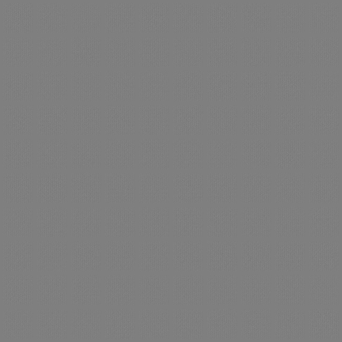

epoch: 0/10, batch: 10/600, G_loss: 0.6624794006347656, D_loss: (0.565267026424408, 0.7248241305351257)
epoch: 0/10, batch: 20/600, G_loss: 0.8569320440292358, D_loss: (0.4782422184944153, 0.5525317192077637)
epoch: 0/10, batch: 30/600, G_loss: 1.149609088897705, D_loss: (0.2996474802494049, 0.38099080324172974)
epoch: 0/10, batch: 40/600, G_loss: 1.3794264793395996, D_loss: (0.21205644309520721, 0.2902260720729828)
epoch: 0/10, batch: 50/600, G_loss: 1.7891907691955566, D_loss: (0.14283064007759094, 0.18335343897342682)
epoch: 0/10, batch: 60/600, G_loss: 2.171896457672119, D_loss: (0.10381904244422913, 0.12538209557533264)
epoch: 0/10, batch: 70/600, G_loss: 2.552443504333496, D_loss: (0.06974434852600098, 0.08193574845790863)
epoch: 0/10, batch: 80/600, G_loss: 2.893662691116333, D_loss: (0.047490790486335754, 0.05872521549463272)
epoch: 0/10, batch: 90/600, G_loss: 3.172450542449951, D_loss: (0.04131900146603584, 0.04284945875406265)
epoch: 0/10, batch: 100/600, G_loss: 3.358864068

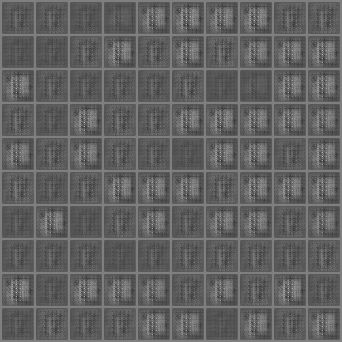

epoch: 0/10, batch: 110/600, G_loss: 3.567415475845337, D_loss: (0.029422903433442116, 0.029440956190228462)
epoch: 0/10, batch: 120/600, G_loss: 1.9721832275390625, D_loss: (0.8040890693664551, 0.3068847358226776)
epoch: 0/10, batch: 130/600, G_loss: 2.756544589996338, D_loss: (0.5977226495742798, 0.07502197474241257)
epoch: 0/10, batch: 140/600, G_loss: 0.6733703017234802, D_loss: (0.031201450154185295, 0.7703109979629517)
epoch: 0/10, batch: 150/600, G_loss: 2.8824243545532227, D_loss: (0.14280830323696136, 0.08458849787712097)
epoch: 0/10, batch: 160/600, G_loss: 3.183128595352173, D_loss: (0.335691899061203, 0.04264397919178009)
epoch: 0/10, batch: 170/600, G_loss: 2.8267297744750977, D_loss: (0.055406007915735245, 0.06403021514415741)
epoch: 0/10, batch: 180/600, G_loss: 3.579313278198242, D_loss: (0.3994022011756897, 0.03290608525276184)
epoch: 0/10, batch: 190/600, G_loss: 0.9314480423927307, D_loss: (0.07949918508529663, 0.5295312404632568)
epoch: 0/10, batch: 200/600, G_loss:

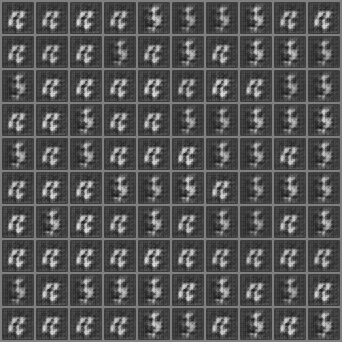

epoch: 0/10, batch: 210/600, G_loss: 0.5929974913597107, D_loss: (0.020433111116290092, 0.8152119517326355)
epoch: 0/10, batch: 220/600, G_loss: 0.5876761674880981, D_loss: (0.04773835092782974, 0.8481578826904297)
epoch: 0/10, batch: 230/600, G_loss: 2.535262107849121, D_loss: (0.47856491804122925, 0.08514679968357086)
epoch: 0/10, batch: 240/600, G_loss: 1.9598039388656616, D_loss: (0.08969603478908539, 0.17458252608776093)
epoch: 0/10, batch: 250/600, G_loss: 2.772958755493164, D_loss: (0.17044515907764435, 0.06605880707502365)
epoch: 0/10, batch: 260/600, G_loss: 2.197909355163574, D_loss: (0.05460061505436897, 0.16138657927513123)
epoch: 0/10, batch: 270/600, G_loss: 2.093104600906372, D_loss: (0.22252438962459564, 0.14307476580142975)
epoch: 0/10, batch: 280/600, G_loss: 1.2145389318466187, D_loss: (0.05126244202256203, 0.3633710443973541)
epoch: 0/10, batch: 290/600, G_loss: 2.06107234954834, D_loss: (0.06267958879470825, 0.14155304431915283)
epoch: 0/10, batch: 300/600, G_loss:

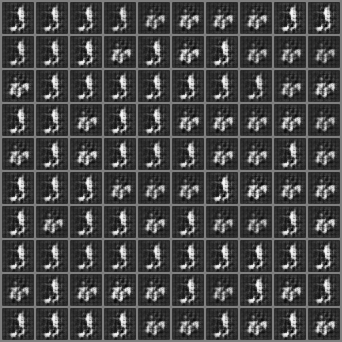

epoch: 0/10, batch: 310/600, G_loss: 2.1051344871520996, D_loss: (0.15134328603744507, 0.13574834167957306)
epoch: 0/10, batch: 320/600, G_loss: 2.0273499488830566, D_loss: (0.12131296843290329, 0.14543664455413818)
epoch: 0/10, batch: 330/600, G_loss: 1.7716279029846191, D_loss: (0.04272822290658951, 0.1869809925556183)
epoch: 0/10, batch: 340/600, G_loss: 1.761641025543213, D_loss: (0.14508134126663208, 0.19076724350452423)
epoch: 0/10, batch: 350/600, G_loss: 1.211442232131958, D_loss: (0.02413986623287201, 0.35974356532096863)
epoch: 0/10, batch: 360/600, G_loss: 2.2490668296813965, D_loss: (0.2095463126897812, 0.11542169749736786)
epoch: 0/10, batch: 370/600, G_loss: 2.592146396636963, D_loss: (0.2214435338973999, 0.08554472029209137)
epoch: 0/10, batch: 380/600, G_loss: 1.7507911920547485, D_loss: (0.10231001675128937, 0.20378009974956512)
epoch: 0/10, batch: 390/600, G_loss: 2.817000389099121, D_loss: (0.11294832825660706, 0.06307035684585571)
epoch: 0/10, batch: 400/600, G_loss

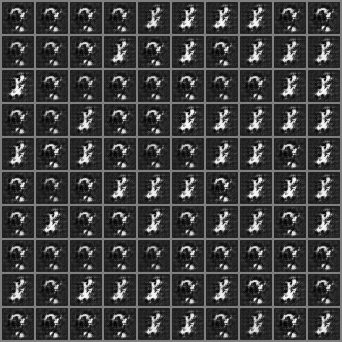

epoch: 0/10, batch: 410/600, G_loss: 1.5649513006210327, D_loss: (0.026619572192430496, 0.8073387742042542)
epoch: 0/10, batch: 420/600, G_loss: 2.685589551925659, D_loss: (0.21350881457328796, 0.07118229568004608)
epoch: 0/10, batch: 430/600, G_loss: 2.119901418685913, D_loss: (0.01776466891169548, 0.1286635398864746)
epoch: 0/10, batch: 440/600, G_loss: 1.737289309501648, D_loss: (0.15470601618289948, 0.19425366818904877)
epoch: 0/10, batch: 450/600, G_loss: 2.978670597076416, D_loss: (0.08508794009685516, 0.05261412262916565)
epoch: 0/10, batch: 460/600, G_loss: 3.2007524967193604, D_loss: (0.01879769004881382, 0.08848945796489716)
epoch: 0/10, batch: 470/600, G_loss: 2.39268159866333, D_loss: (0.08204317837953568, 0.09749796241521835)
epoch: 0/10, batch: 480/600, G_loss: 4.025742053985596, D_loss: (0.08730936795473099, 0.019653266295790672)
epoch: 0/10, batch: 490/600, G_loss: 1.8266505002975464, D_loss: (0.04854074865579605, 0.22879457473754883)
epoch: 0/10, batch: 500/600, G_loss

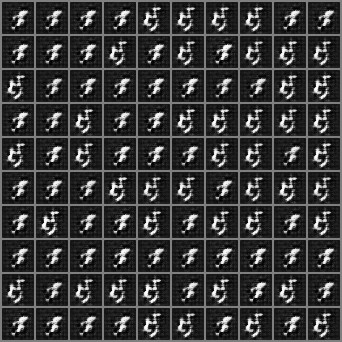

epoch: 0/10, batch: 510/600, G_loss: 1.5757699012756348, D_loss: (0.030405964702367783, 0.2487388551235199)
epoch: 0/10, batch: 520/600, G_loss: 0.162117138504982, D_loss: (0.004173727706074715, 2.179903745651245)
epoch: 0/10, batch: 530/600, G_loss: 2.0758252143859863, D_loss: (0.11356448382139206, 0.13534480333328247)
epoch: 0/10, batch: 540/600, G_loss: 1.9804120063781738, D_loss: (0.10003577917814255, 0.1494160294532776)
epoch: 0/10, batch: 550/600, G_loss: 2.9159936904907227, D_loss: (0.45973488688468933, 0.05759050324559212)
epoch: 0/10, batch: 560/600, G_loss: 2.025848150253296, D_loss: (0.10528580844402313, 0.1483086198568344)
epoch: 0/10, batch: 570/600, G_loss: 2.1265318393707275, D_loss: (0.0772416889667511, 0.34329113364219666)
epoch: 0/10, batch: 580/600, G_loss: 2.0615897178649902, D_loss: (0.2734434902667999, 0.13812120258808136)
epoch: 0/10, batch: 590/600, G_loss: 3.1006524562835693, D_loss: (0.28836068511009216, 0.1954949051141739)
epoch: 1/10, batch: 0/600, G_loss: 2

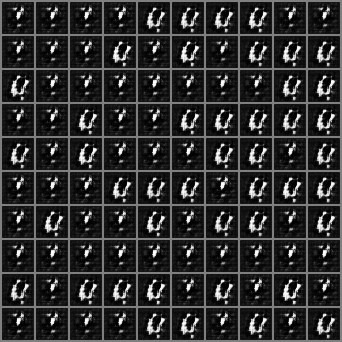

epoch: 1/10, batch: 10/600, G_loss: 2.0383901596069336, D_loss: (0.12803252041339874, 0.14045214653015137)
epoch: 1/10, batch: 20/600, G_loss: 3.75819730758667, D_loss: (0.16536672413349152, 0.03328002989292145)
epoch: 1/10, batch: 30/600, G_loss: 3.6232428550720215, D_loss: (0.10196518898010254, 0.027244828641414642)
epoch: 1/10, batch: 40/600, G_loss: 2.1159636974334717, D_loss: (0.09416761249303818, 0.1301618069410324)
epoch: 1/10, batch: 50/600, G_loss: 2.4199516773223877, D_loss: (0.2586572766304016, 0.10141624510288239)
epoch: 1/10, batch: 60/600, G_loss: 2.751711845397949, D_loss: (0.10095876455307007, 0.09566844254732132)
epoch: 1/10, batch: 70/600, G_loss: 2.3868672847747803, D_loss: (0.2648348808288574, 0.10194601118564606)
epoch: 1/10, batch: 80/600, G_loss: 2.941126823425293, D_loss: (0.2054063081741333, 0.0569630041718483)
epoch: 1/10, batch: 90/600, G_loss: 4.1458659172058105, D_loss: (0.7283405065536499, 0.01629592292010784)
epoch: 1/10, batch: 100/600, G_loss: 2.9603579

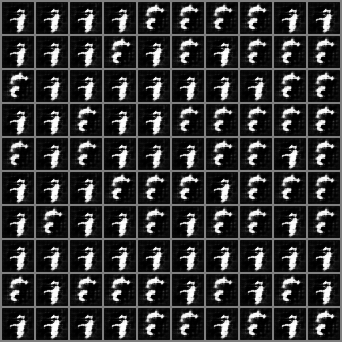

epoch: 1/10, batch: 110/600, G_loss: 2.1339519023895264, D_loss: (0.21999341249465942, 0.1298508495092392)
epoch: 1/10, batch: 120/600, G_loss: 5.6234259605407715, D_loss: (0.5745947360992432, 0.005680065602064133)
epoch: 1/10, batch: 130/600, G_loss: 4.250536918640137, D_loss: (0.5044815540313721, 0.018288562074303627)
epoch: 1/10, batch: 140/600, G_loss: 2.793104887008667, D_loss: (0.19639916718006134, 0.06500449776649475)
epoch: 1/10, batch: 150/600, G_loss: 4.430090427398682, D_loss: (0.11865536868572235, 0.024587877094745636)
epoch: 1/10, batch: 160/600, G_loss: 3.063403606414795, D_loss: (0.14863279461860657, 0.04808274284005165)
epoch: 1/10, batch: 170/600, G_loss: 2.286743402481079, D_loss: (0.07482659071683884, 0.1305721402168274)
epoch: 1/10, batch: 180/600, G_loss: 1.6475523710250854, D_loss: (0.190792515873909, 0.24552612006664276)
epoch: 1/10, batch: 190/600, G_loss: 2.0674047470092773, D_loss: (0.1250361204147339, 0.1386837214231491)
epoch: 1/10, batch: 200/600, G_loss: 2

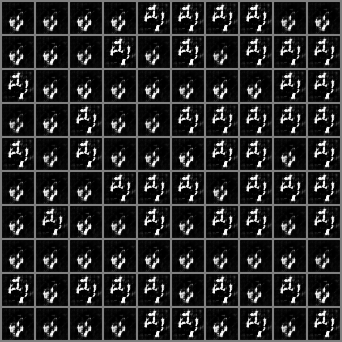

epoch: 1/10, batch: 210/600, G_loss: 2.028435230255127, D_loss: (0.19743438065052032, 0.1514163464307785)
epoch: 1/10, batch: 220/600, G_loss: 2.4337990283966064, D_loss: (0.09746506065130234, 0.09300234168767929)
epoch: 1/10, batch: 230/600, G_loss: 3.6916720867156982, D_loss: (0.3408515453338623, 0.02989707514643669)
epoch: 1/10, batch: 240/600, G_loss: 4.115619659423828, D_loss: (0.20065076649188995, 0.0694613829255104)
epoch: 1/10, batch: 250/600, G_loss: 2.342012405395508, D_loss: (0.14799503982067108, 0.10143496841192245)
epoch: 1/10, batch: 260/600, G_loss: 2.8111536502838135, D_loss: (0.11975156515836716, 0.062450483441352844)
epoch: 1/10, batch: 270/600, G_loss: 8.429162979125977, D_loss: (1.8694658279418945, 0.0006281297537498176)
epoch: 1/10, batch: 280/600, G_loss: 1.8957592248916626, D_loss: (0.08638698607683182, 0.1629919558763504)
epoch: 1/10, batch: 290/600, G_loss: 4.510720729827881, D_loss: (0.11944403499364853, 0.013705167919397354)
epoch: 1/10, batch: 300/600, G_los

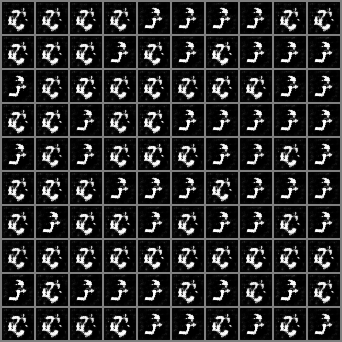

epoch: 1/10, batch: 310/600, G_loss: 3.2375478744506836, D_loss: (0.07763608545064926, 0.0590272918343544)
epoch: 1/10, batch: 320/600, G_loss: 5.396948337554932, D_loss: (0.44897329807281494, 0.005521425046026707)
epoch: 1/10, batch: 330/600, G_loss: 1.9598710536956787, D_loss: (0.12477356195449829, 0.17106470465660095)
epoch: 1/10, batch: 340/600, G_loss: 3.0168373584747314, D_loss: (0.10090275853872299, 0.05077777057886124)
epoch: 1/10, batch: 350/600, G_loss: 2.709141731262207, D_loss: (0.238393172621727, 0.0715593695640564)
epoch: 1/10, batch: 360/600, G_loss: 3.1473188400268555, D_loss: (0.16324512660503387, 0.045601364225149155)
epoch: 1/10, batch: 370/600, G_loss: 2.145139694213867, D_loss: (0.06286142021417618, 0.1281730979681015)
epoch: 1/10, batch: 380/600, G_loss: 2.6140758991241455, D_loss: (0.06883115321397781, 0.07613615691661835)
epoch: 1/10, batch: 390/600, G_loss: 2.651047706604004, D_loss: (0.08363442122936249, 0.0762459933757782)
epoch: 1/10, batch: 400/600, G_loss:

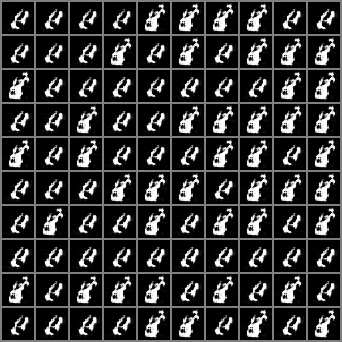

epoch: 1/10, batch: 410/600, G_loss: 4.8647356033325195, D_loss: (0.41489875316619873, 0.008112027309834957)
epoch: 1/10, batch: 420/600, G_loss: 2.9062345027923584, D_loss: (0.060508422553539276, 0.05627831816673279)
epoch: 1/10, batch: 430/600, G_loss: 2.6296441555023193, D_loss: (0.10160885006189346, 0.08267419785261154)
epoch: 1/10, batch: 440/600, G_loss: 4.106103897094727, D_loss: (0.02222793735563755, 0.04219941794872284)
epoch: 1/10, batch: 450/600, G_loss: 6.789063930511475, D_loss: (0.805930495262146, 0.001147402566857636)
epoch: 1/10, batch: 460/600, G_loss: 2.344099283218384, D_loss: (0.1928364783525467, 0.15784259140491486)
epoch: 1/10, batch: 470/600, G_loss: 3.1174933910369873, D_loss: (0.16678637266159058, 0.06532271951436996)
epoch: 1/10, batch: 480/600, G_loss: 4.049096584320068, D_loss: (0.1256849318742752, 0.03911520540714264)
epoch: 1/10, batch: 490/600, G_loss: 2.127047538757324, D_loss: (0.08128693699836731, 0.13396959006786346)
epoch: 1/10, batch: 500/600, G_los

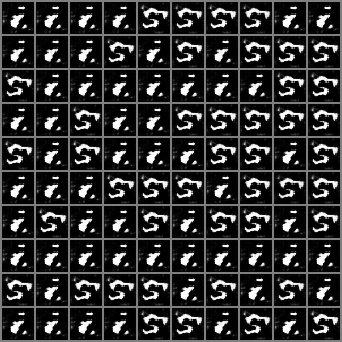

epoch: 1/10, batch: 510/600, G_loss: 3.2925989627838135, D_loss: (0.1372685581445694, 0.0383269228041172)
epoch: 1/10, batch: 520/600, G_loss: 10.800167083740234, D_loss: (3.12576961517334, 4.802456169272773e-05)
epoch: 1/10, batch: 530/600, G_loss: 1.8709955215454102, D_loss: (0.09864404797554016, 0.1690993756055832)
epoch: 1/10, batch: 540/600, G_loss: 3.802227735519409, D_loss: (0.20983995497226715, 0.04961015656590462)
epoch: 1/10, batch: 550/600, G_loss: 2.708103656768799, D_loss: (0.17408668994903564, 0.07611269503831863)
epoch: 1/10, batch: 560/600, G_loss: 3.0782837867736816, D_loss: (0.12905572354793549, 0.04762028530240059)
epoch: 1/10, batch: 570/600, G_loss: 3.6023354530334473, D_loss: (0.061420511454343796, 0.028793171048164368)
epoch: 1/10, batch: 580/600, G_loss: 2.3356120586395264, D_loss: (0.0708903819322586, 0.1056247428059578)
epoch: 1/10, batch: 590/600, G_loss: 4.390868186950684, D_loss: (0.07545270025730133, 0.012710418552160263)
epoch: 2/10, batch: 0/600, G_loss:

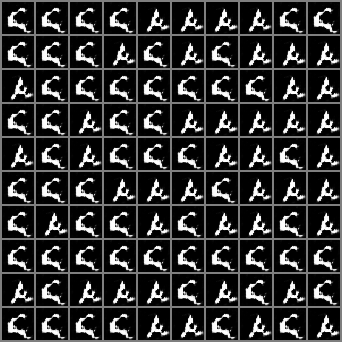

epoch: 2/10, batch: 10/600, G_loss: 2.35739803314209, D_loss: (0.08612915128469467, 0.09963560849428177)
epoch: 2/10, batch: 20/600, G_loss: 6.08232307434082, D_loss: (0.18825457990169525, 0.0049991668201982975)
epoch: 2/10, batch: 30/600, G_loss: 3.5563039779663086, D_loss: (0.030835185199975967, 0.17350375652313232)
epoch: 2/10, batch: 40/600, G_loss: 3.8400800228118896, D_loss: (0.05566360428929329, 0.02391200140118599)
epoch: 2/10, batch: 50/600, G_loss: 4.523621559143066, D_loss: (0.03710523992776871, 0.02051062136888504)
epoch: 2/10, batch: 60/600, G_loss: 2.4947783946990967, D_loss: (0.049870505928993225, 0.09437396377325058)
epoch: 2/10, batch: 70/600, G_loss: 4.1148576736450195, D_loss: (0.037045661360025406, 0.01714586466550827)
epoch: 2/10, batch: 80/600, G_loss: 3.487529993057251, D_loss: (0.044219907373189926, 0.03254799544811249)
epoch: 2/10, batch: 90/600, G_loss: 2.4821512699127197, D_loss: (0.05456487089395523, 0.08811075240373611)
epoch: 2/10, batch: 100/600, G_loss: 

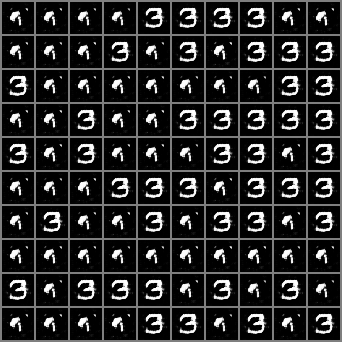

epoch: 2/10, batch: 110/600, G_loss: 6.124639511108398, D_loss: (0.04116366431117058, 0.0033052293583750725)
epoch: 2/10, batch: 120/600, G_loss: 7.427960395812988, D_loss: (0.9727804064750671, 0.0011223801411688328)
epoch: 2/10, batch: 130/600, G_loss: 1.8481085300445557, D_loss: (0.11468610912561417, 0.18173013627529144)
epoch: 2/10, batch: 140/600, G_loss: 2.8816049098968506, D_loss: (0.03033052757382393, 0.06537536531686783)
epoch: 2/10, batch: 150/600, G_loss: 3.832211971282959, D_loss: (0.13729128241539001, 0.06304845958948135)
epoch: 2/10, batch: 160/600, G_loss: 2.118245840072632, D_loss: (0.028046980500221252, 0.1325184404850006)
epoch: 2/10, batch: 170/600, G_loss: 2.7439310550689697, D_loss: (0.03485134243965149, 0.1471184492111206)
epoch: 2/10, batch: 180/600, G_loss: 3.700887680053711, D_loss: (0.15226492285728455, 0.02627956122159958)
epoch: 2/10, batch: 190/600, G_loss: 2.6044397354125977, D_loss: (0.19142471253871918, 0.08759298175573349)
epoch: 2/10, batch: 200/600, G_

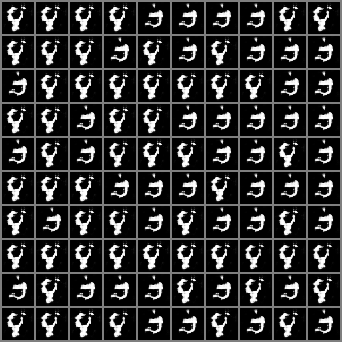

epoch: 2/10, batch: 210/600, G_loss: 2.7093679904937744, D_loss: (0.06578926742076874, 0.08565512299537659)
epoch: 2/10, batch: 220/600, G_loss: 8.209049224853516, D_loss: (0.08844107389450073, 0.0005137579282745719)
epoch: 2/10, batch: 230/600, G_loss: 3.549654483795166, D_loss: (0.11400416493415833, 0.031030042096972466)
epoch: 2/10, batch: 240/600, G_loss: 3.41267466545105, D_loss: (0.186826691031456, 0.03500918298959732)
epoch: 2/10, batch: 250/600, G_loss: 4.223982334136963, D_loss: (0.035697851330041885, 0.015485953539609909)
epoch: 2/10, batch: 260/600, G_loss: 2.9370627403259277, D_loss: (0.04896363243460655, 0.08901520818471909)
epoch: 2/10, batch: 270/600, G_loss: 3.2278854846954346, D_loss: (0.04190481826663017, 0.04057373106479645)
epoch: 2/10, batch: 280/600, G_loss: 5.236201286315918, D_loss: (0.0564136803150177, 0.005991220474243164)
epoch: 2/10, batch: 290/600, G_loss: 2.952152729034424, D_loss: (0.08210320770740509, 0.05633274465799332)
epoch: 2/10, batch: 300/600, G_l

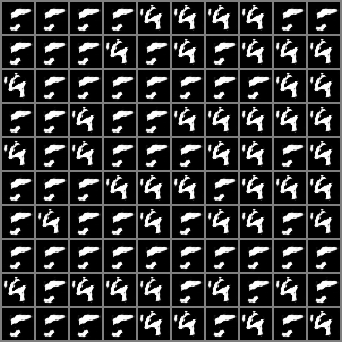

epoch: 2/10, batch: 310/600, G_loss: 3.2855842113494873, D_loss: (0.05175556614995003, 0.03990708291530609)
epoch: 2/10, batch: 320/600, G_loss: 3.6261823177337646, D_loss: (0.04654456675052643, 0.05036069080233574)
epoch: 2/10, batch: 330/600, G_loss: 12.968526840209961, D_loss: (2.3600213527679443, 3.088582161581144e-05)
epoch: 2/10, batch: 340/600, G_loss: 1.9632374048233032, D_loss: (0.09175869822502136, 0.17214584350585938)
epoch: 2/10, batch: 350/600, G_loss: 5.1016154289245605, D_loss: (0.011224490590393543, 0.047401756048202515)
epoch: 2/10, batch: 360/600, G_loss: 2.6900196075439453, D_loss: (0.04402657598257065, 0.08418414741754532)
epoch: 2/10, batch: 370/600, G_loss: 2.1616666316986084, D_loss: (0.009126684628427029, 0.17971864342689514)
epoch: 2/10, batch: 380/600, G_loss: 2.9092037677764893, D_loss: (0.044274043291807175, 0.05942809209227562)
epoch: 2/10, batch: 390/600, G_loss: 3.5683095455169678, D_loss: (0.04968959838151932, 0.030270135030150414)
epoch: 2/10, batch: 40

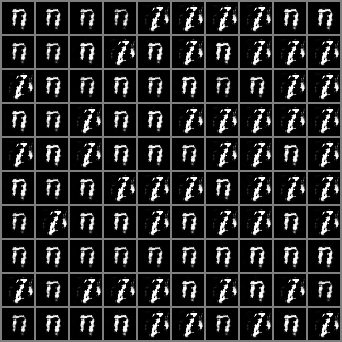

epoch: 2/10, batch: 410/600, G_loss: 3.422436237335205, D_loss: (0.02905905432999134, 0.039550360292196274)
epoch: 2/10, batch: 420/600, G_loss: 3.1363348960876465, D_loss: (0.04087921231985092, 0.044503770768642426)
epoch: 2/10, batch: 430/600, G_loss: 2.6938130855560303, D_loss: (0.000320098246447742, 1.0955665111541748)
epoch: 2/10, batch: 440/600, G_loss: 5.139150619506836, D_loss: (0.05597098171710968, 0.026119990274310112)
epoch: 2/10, batch: 450/600, G_loss: 3.7232797145843506, D_loss: (0.21475544571876526, 0.030915802344679832)
epoch: 2/10, batch: 460/600, G_loss: 3.9703807830810547, D_loss: (0.04691508412361145, 0.02248579077422619)
epoch: 2/10, batch: 470/600, G_loss: 2.3819711208343506, D_loss: (0.03372456878423691, 0.11521749198436737)
epoch: 2/10, batch: 480/600, G_loss: 3.1352782249450684, D_loss: (0.0725044459104538, 0.052636269479990005)
epoch: 2/10, batch: 490/600, G_loss: 3.151904582977295, D_loss: (0.09430480748414993, 0.07108420133590698)
epoch: 2/10, batch: 500/600

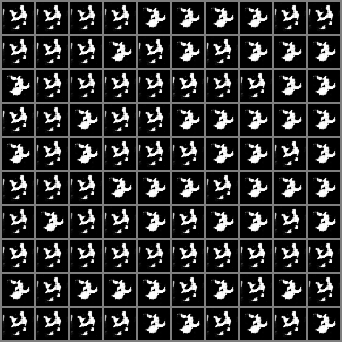

epoch: 2/10, batch: 510/600, G_loss: 2.4424855709075928, D_loss: (0.03613494336605072, 0.1055583730340004)
epoch: 2/10, batch: 520/600, G_loss: 3.8685717582702637, D_loss: (0.1062544658780098, 0.04012928903102875)
epoch: 2/10, batch: 530/600, G_loss: 2.9690358638763428, D_loss: (0.16851253807544708, 0.062322184443473816)
epoch: 2/10, batch: 540/600, G_loss: 3.001039743423462, D_loss: (0.0382070355117321, 0.05195511877536774)
epoch: 2/10, batch: 550/600, G_loss: 3.351289987564087, D_loss: (0.026795094832777977, 0.03798332065343857)
epoch: 2/10, batch: 560/600, G_loss: 4.8126020431518555, D_loss: (0.024421805515885353, 0.012027448043227196)
epoch: 2/10, batch: 570/600, G_loss: 3.667019844055176, D_loss: (0.19756005704402924, 0.026009995490312576)
epoch: 2/10, batch: 580/600, G_loss: 4.09584379196167, D_loss: (0.01784554310142994, 0.020043380558490753)
epoch: 2/10, batch: 590/600, G_loss: 2.9398598670959473, D_loss: (0.09720209985971451, 0.054575834423303604)
epoch: 3/10, batch: 0/600, G_

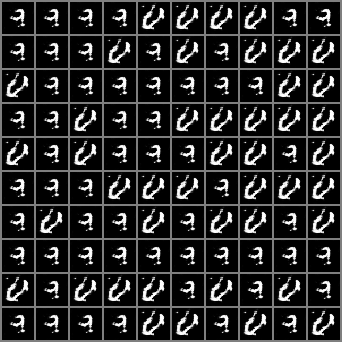

epoch: 3/10, batch: 10/600, G_loss: 4.118384838104248, D_loss: (0.12819628417491913, 0.02167385071516037)
epoch: 3/10, batch: 20/600, G_loss: 2.6183784008026123, D_loss: (0.030764140188694, 0.07983902841806412)
epoch: 3/10, batch: 30/600, G_loss: 2.879206895828247, D_loss: (0.020321911200881004, 0.06475668400526047)
epoch: 3/10, batch: 40/600, G_loss: 3.1397531032562256, D_loss: (0.06033404916524887, 0.04723968356847763)
epoch: 3/10, batch: 50/600, G_loss: 5.34330940246582, D_loss: (0.011154179461300373, 0.004876637831330299)
epoch: 3/10, batch: 60/600, G_loss: 4.13512659072876, D_loss: (0.02325722761452198, 0.01622532680630684)
epoch: 3/10, batch: 70/600, G_loss: 4.918941020965576, D_loss: (0.10222557932138443, 0.00921943224966526)
epoch: 3/10, batch: 80/600, G_loss: 3.6262264251708984, D_loss: (0.05398014932870865, 0.029846705496311188)
epoch: 3/10, batch: 90/600, G_loss: 1.010288953781128, D_loss: (0.02183084562420845, 0.530921459197998)
epoch: 3/10, batch: 100/600, G_loss: 3.350702

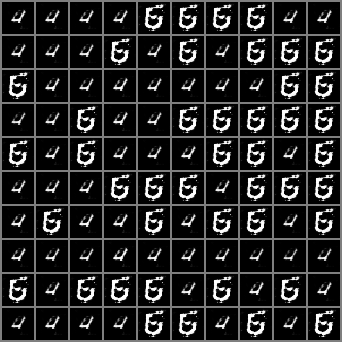

epoch: 3/10, batch: 110/600, G_loss: 2.2924962043762207, D_loss: (0.06761717796325684, 0.10721717029809952)
epoch: 3/10, batch: 120/600, G_loss: 2.2156128883361816, D_loss: (0.08612532913684845, 0.11810337752103806)
epoch: 3/10, batch: 130/600, G_loss: 1.270906925201416, D_loss: (0.000645978027023375, 0.35603779554367065)
epoch: 3/10, batch: 140/600, G_loss: 5.068896770477295, D_loss: (0.07845757901668549, 0.007136983796954155)
epoch: 3/10, batch: 150/600, G_loss: 3.351599931716919, D_loss: (0.0483851283788681, 0.038081321865320206)
epoch: 3/10, batch: 160/600, G_loss: 4.48227071762085, D_loss: (0.03932575136423111, 0.014027508907020092)
epoch: 3/10, batch: 170/600, G_loss: 4.292556285858154, D_loss: (0.004670057911425829, 0.01699969172477722)
epoch: 3/10, batch: 180/600, G_loss: 3.2352423667907715, D_loss: (0.07365434616804123, 0.040478020906448364)
epoch: 3/10, batch: 190/600, G_loss: 5.172269344329834, D_loss: (0.30021119117736816, 0.009661804884672165)
epoch: 3/10, batch: 200/600, 

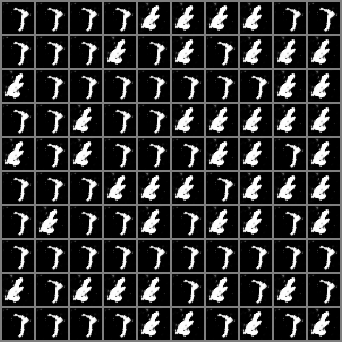

epoch: 3/10, batch: 210/600, G_loss: 2.6470367908477783, D_loss: (0.05452798306941986, 0.07841942459344864)
epoch: 3/10, batch: 220/600, G_loss: 4.6294403076171875, D_loss: (0.043355945497751236, 0.01192538533359766)
epoch: 3/10, batch: 230/600, G_loss: 5.6911702156066895, D_loss: (0.18458455801010132, 0.0043596429750323296)
epoch: 3/10, batch: 240/600, G_loss: 3.7371768951416016, D_loss: (0.062044523656368256, 0.03686579316854477)
epoch: 3/10, batch: 250/600, G_loss: 2.968033790588379, D_loss: (0.0406612902879715, 0.05715722590684891)
epoch: 3/10, batch: 260/600, G_loss: 3.4420220851898193, D_loss: (0.016648177057504654, 0.03290179371833801)
epoch: 3/10, batch: 270/600, G_loss: 5.096250534057617, D_loss: (0.02744041010737419, 0.020599622279405594)
epoch: 3/10, batch: 280/600, G_loss: 4.3110551834106445, D_loss: (0.03438856452703476, 0.014347152784466743)
epoch: 3/10, batch: 290/600, G_loss: 3.9969911575317383, D_loss: (0.08423437178134918, 0.02031455561518669)
epoch: 3/10, batch: 300/

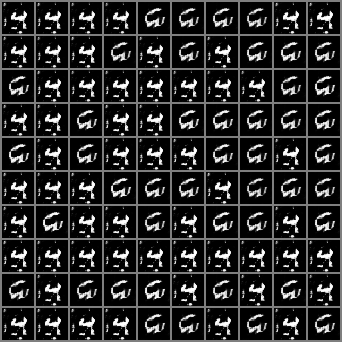

epoch: 3/10, batch: 310/600, G_loss: 7.040930271148682, D_loss: (0.00017787941033020616, 0.02474907599389553)
epoch: 3/10, batch: 320/600, G_loss: 10.556897163391113, D_loss: (2.3475966453552246, 0.0007539288490079343)
epoch: 3/10, batch: 330/600, G_loss: 3.483553886413574, D_loss: (0.07110966742038727, 0.0364372581243515)
epoch: 3/10, batch: 340/600, G_loss: 7.17144775390625, D_loss: (0.003263924503698945, 0.0011117073008790612)
epoch: 3/10, batch: 350/600, G_loss: 3.4111592769622803, D_loss: (0.09048227220773697, 0.034592434763908386)
epoch: 3/10, batch: 360/600, G_loss: 3.1267011165618896, D_loss: (0.08788106590509415, 0.04766666889190674)
epoch: 3/10, batch: 370/600, G_loss: 1.7458946704864502, D_loss: (0.05865980312228203, 0.21189241111278534)
epoch: 3/10, batch: 380/600, G_loss: 3.575514316558838, D_loss: (0.01746857911348343, 0.028657613322138786)
epoch: 3/10, batch: 390/600, G_loss: 3.7452993392944336, D_loss: (0.049243293702602386, 0.027135353535413742)
epoch: 3/10, batch: 400

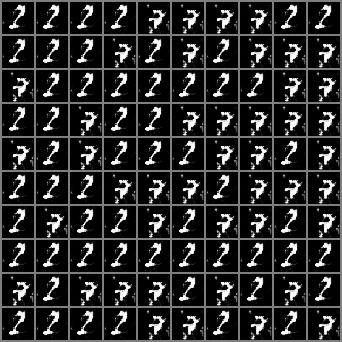

epoch: 3/10, batch: 410/600, G_loss: 4.973689079284668, D_loss: (0.01974613219499588, 0.025851495563983917)
epoch: 3/10, batch: 420/600, G_loss: 2.9181318283081055, D_loss: (0.03550656884908676, 0.10864629596471786)
epoch: 3/10, batch: 430/600, G_loss: 2.831120491027832, D_loss: (0.1957959234714508, 0.16644799709320068)
epoch: 3/10, batch: 440/600, G_loss: 2.3807873725891113, D_loss: (0.04136587679386139, 0.1129421591758728)
epoch: 3/10, batch: 450/600, G_loss: 3.1784708499908447, D_loss: (0.03081412799656391, 0.0434446819126606)
epoch: 3/10, batch: 460/600, G_loss: 3.8455686569213867, D_loss: (0.08123257011175156, 0.03326943889260292)
epoch: 3/10, batch: 470/600, G_loss: 0.5490714907646179, D_loss: (0.01457052119076252, 0.9829170107841492)
epoch: 3/10, batch: 480/600, G_loss: 2.935758352279663, D_loss: (0.03900783881545067, 0.06991018354892731)
epoch: 3/10, batch: 490/600, G_loss: 3.1262428760528564, D_loss: (0.05038776993751526, 0.05591602250933647)
epoch: 3/10, batch: 500/600, G_los

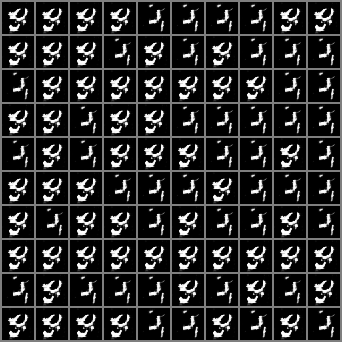

epoch: 3/10, batch: 510/600, G_loss: 3.6827707290649414, D_loss: (0.020027853548526764, 0.02572472393512726)
epoch: 3/10, batch: 520/600, G_loss: 3.2692089080810547, D_loss: (0.07656751573085785, 0.03935859352350235)
epoch: 3/10, batch: 530/600, G_loss: 14.462424278259277, D_loss: (3.912142038345337, 3.1978006518329494e-06)
epoch: 3/10, batch: 540/600, G_loss: 4.613461017608643, D_loss: (0.01736757904291153, 0.010018240660429)
epoch: 3/10, batch: 550/600, G_loss: 2.6867265701293945, D_loss: (0.022587742656469345, 0.07175292074680328)
epoch: 3/10, batch: 560/600, G_loss: 3.198272943496704, D_loss: (0.055457428097724915, 0.04369572177529335)
epoch: 3/10, batch: 570/600, G_loss: 3.086158514022827, D_loss: (0.03304077312350273, 0.046912819147109985)
epoch: 3/10, batch: 580/600, G_loss: 3.3694963455200195, D_loss: (0.015596438199281693, 0.035618897527456284)
epoch: 3/10, batch: 590/600, G_loss: 3.1385316848754883, D_loss: (0.03275112807750702, 0.04527932032942772)
epoch: 4/10, batch: 0/600,

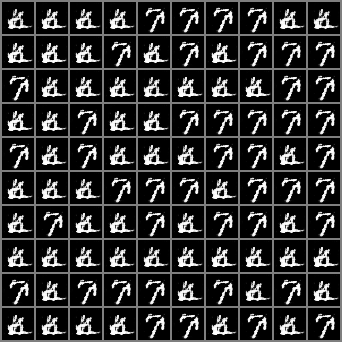

epoch: 4/10, batch: 10/600, G_loss: 4.922256946563721, D_loss: (0.053137339651584625, 0.010089682415127754)
epoch: 4/10, batch: 20/600, G_loss: 3.118427038192749, D_loss: (0.021758003160357475, 0.047018323093652725)
epoch: 4/10, batch: 30/600, G_loss: 3.1114816665649414, D_loss: (0.11523222178220749, 0.04923936352133751)
epoch: 4/10, batch: 40/600, G_loss: 2.804187297821045, D_loss: (0.014860158786177635, 0.08600601553916931)
epoch: 4/10, batch: 50/600, G_loss: 2.473661422729492, D_loss: (0.063194639980793, 0.12030910700559616)
epoch: 4/10, batch: 60/600, G_loss: 3.865929365158081, D_loss: (0.0609891302883625, 0.022478120401501656)
epoch: 4/10, batch: 70/600, G_loss: 4.015475273132324, D_loss: (0.14372462034225464, 0.018942885100841522)
epoch: 4/10, batch: 80/600, G_loss: 2.2502248287200928, D_loss: (0.014628857374191284, 0.11174555122852325)
epoch: 4/10, batch: 90/600, G_loss: 7.007863998413086, D_loss: (0.006973109673708677, 0.0067015658132731915)
epoch: 4/10, batch: 100/600, G_loss:

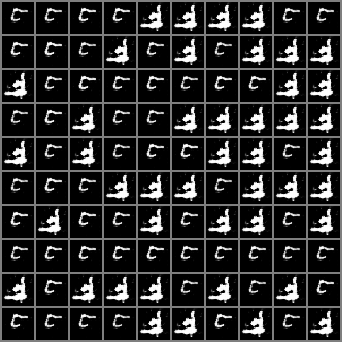

epoch: 4/10, batch: 110/600, G_loss: 3.294703483581543, D_loss: (0.02836153656244278, 0.04095887020230293)
epoch: 4/10, batch: 120/600, G_loss: 3.3068811893463135, D_loss: (0.021474415436387062, 0.04012306034564972)
epoch: 4/10, batch: 130/600, G_loss: 3.4796571731567383, D_loss: (0.030370254069566727, 0.032179929316043854)
epoch: 4/10, batch: 140/600, G_loss: 4.018214702606201, D_loss: (0.030432002618908882, 0.018922219052910805)
epoch: 4/10, batch: 150/600, G_loss: 2.3544983863830566, D_loss: (0.20139369368553162, 0.10000167787075043)
epoch: 4/10, batch: 160/600, G_loss: 6.604467868804932, D_loss: (0.005625216290354729, 0.00267541641369462)
epoch: 4/10, batch: 170/600, G_loss: 3.7933237552642822, D_loss: (0.031524658203125, 0.023923194035887718)
epoch: 4/10, batch: 180/600, G_loss: 1.947546362876892, D_loss: (0.036493610590696335, 0.15515968203544617)
epoch: 4/10, batch: 190/600, G_loss: 2.6758506298065186, D_loss: (0.017239535227417946, 0.07569754123687744)
epoch: 4/10, batch: 200/6

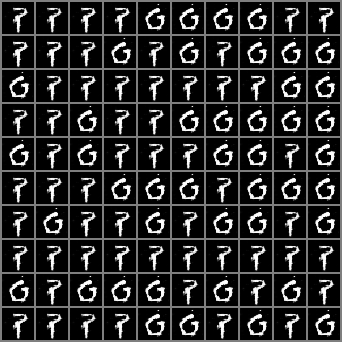

epoch: 4/10, batch: 210/600, G_loss: 7.623137950897217, D_loss: (0.10692700743675232, 0.013785076327621937)
epoch: 4/10, batch: 220/600, G_loss: 2.4685654640197754, D_loss: (0.06439592689275742, 0.0959697812795639)
epoch: 4/10, batch: 230/600, G_loss: 3.531874179840088, D_loss: (0.062025465071201324, 0.03731299564242363)
epoch: 4/10, batch: 240/600, G_loss: 2.7366859912872314, D_loss: (0.04684378206729889, 0.0691690593957901)
epoch: 4/10, batch: 250/600, G_loss: 3.501601219177246, D_loss: (0.04306968301534653, 0.03190172091126442)
epoch: 4/10, batch: 260/600, G_loss: 3.2813260555267334, D_loss: (0.026426680386066437, 0.039181824773550034)
epoch: 4/10, batch: 270/600, G_loss: 3.6282849311828613, D_loss: (0.0420573428273201, 0.027019880712032318)
epoch: 4/10, batch: 280/600, G_loss: 3.118382453918457, D_loss: (0.037047091871500015, 0.09455421566963196)
epoch: 4/10, batch: 290/600, G_loss: 6.003688335418701, D_loss: (0.026997361332178116, 0.002479789312928915)
epoch: 4/10, batch: 300/600,

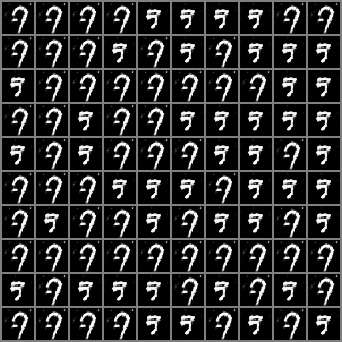

epoch: 4/10, batch: 310/600, G_loss: 3.3575305938720703, D_loss: (0.10758264362812042, 0.038895901292562485)
epoch: 4/10, batch: 320/600, G_loss: 4.006855010986328, D_loss: (0.04794558510184288, 0.028572505339980125)
epoch: 4/10, batch: 330/600, G_loss: 3.102210283279419, D_loss: (0.0337071418762207, 0.04719345644116402)
epoch: 4/10, batch: 340/600, G_loss: 2.512366533279419, D_loss: (0.044745221734046936, 0.08488235622644424)
epoch: 4/10, batch: 350/600, G_loss: 4.013123989105225, D_loss: (0.04700504615902901, 0.02337285503745079)
epoch: 4/10, batch: 360/600, G_loss: 3.6051552295684814, D_loss: (0.09933986514806747, 0.02810852602124214)
epoch: 4/10, batch: 370/600, G_loss: 5.618707656860352, D_loss: (0.15991230309009552, 0.006315716076642275)
epoch: 4/10, batch: 380/600, G_loss: 4.041095733642578, D_loss: (0.04387366771697998, 0.018626714125275612)
epoch: 4/10, batch: 390/600, G_loss: 4.069585800170898, D_loss: (0.03824659436941147, 0.017237810418009758)
epoch: 4/10, batch: 400/600, G

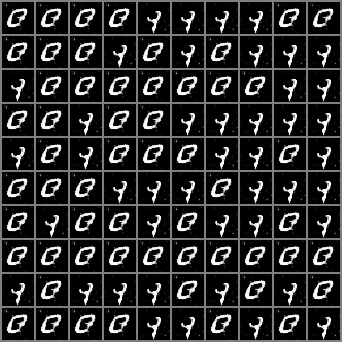

epoch: 4/10, batch: 410/600, G_loss: 3.356238603591919, D_loss: (0.015444577671587467, 0.060541749000549316)
epoch: 4/10, batch: 420/600, G_loss: 6.98808479309082, D_loss: (0.03502779081463814, 0.029564907774329185)
epoch: 4/10, batch: 430/600, G_loss: 3.3374712467193604, D_loss: (0.09557214379310608, 0.04792238399386406)
epoch: 4/10, batch: 440/600, G_loss: 2.952606201171875, D_loss: (0.02501825988292694, 0.05909353867173195)
epoch: 4/10, batch: 450/600, G_loss: 3.784538984298706, D_loss: (0.004263656213879585, 0.028857186436653137)
epoch: 4/10, batch: 460/600, G_loss: 7.646954536437988, D_loss: (0.0018761855317279696, 0.0009016645490191877)
epoch: 4/10, batch: 470/600, G_loss: 5.3955769538879395, D_loss: (0.0032983901910483837, 0.061444565653800964)
epoch: 4/10, batch: 480/600, G_loss: 8.374159812927246, D_loss: (0.3295884430408478, 0.03044820763170719)
epoch: 4/10, batch: 490/600, G_loss: 5.3531694412231445, D_loss: (0.031526897102594376, 0.009777835570275784)
epoch: 4/10, batch: 50

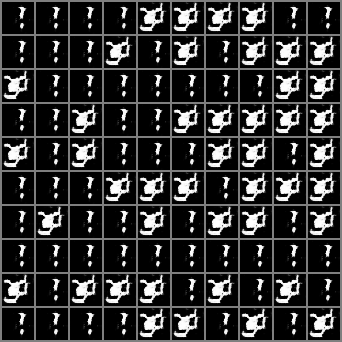

epoch: 4/10, batch: 510/600, G_loss: 3.836996078491211, D_loss: (0.029302120208740234, 0.022596178576350212)
epoch: 4/10, batch: 520/600, G_loss: 3.4384570121765137, D_loss: (0.1022680476307869, 0.03346385061740875)
epoch: 4/10, batch: 530/600, G_loss: 2.545762062072754, D_loss: (0.013335050083696842, 0.09140528738498688)
epoch: 4/10, batch: 540/600, G_loss: 10.810657501220703, D_loss: (0.06288111954927444, 9.010019857669249e-05)
epoch: 4/10, batch: 550/600, G_loss: 3.054896831512451, D_loss: (0.1718018352985382, 0.04982361942529678)
epoch: 4/10, batch: 560/600, G_loss: 2.061738967895508, D_loss: (0.02687920071184635, 0.14731863141059875)
epoch: 4/10, batch: 570/600, G_loss: 3.921870708465576, D_loss: (0.04161294549703598, 0.022720202803611755)
epoch: 4/10, batch: 580/600, G_loss: 3.445464849472046, D_loss: (0.0551711805164814, 0.04219623655080795)
epoch: 4/10, batch: 590/600, G_loss: 3.0636959075927734, D_loss: (0.038520295172929764, 0.051565226167440414)
epoch: 5/10, batch: 0/600, G_

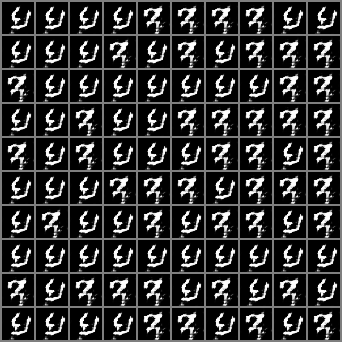

epoch: 5/10, batch: 10/600, G_loss: 4.631383895874023, D_loss: (0.12207961827516556, 0.011877658776938915)
epoch: 5/10, batch: 20/600, G_loss: 3.6864845752716064, D_loss: (0.030580423772335052, 0.028297295793890953)
epoch: 5/10, batch: 30/600, G_loss: 11.294285774230957, D_loss: (1.1978780031204224, 0.0001515183103037998)
epoch: 5/10, batch: 40/600, G_loss: 5.094776630401611, D_loss: (0.05670107528567314, 0.10847023129463196)
epoch: 5/10, batch: 50/600, G_loss: 3.1444382667541504, D_loss: (0.08878558874130249, 0.045915473252534866)
epoch: 5/10, batch: 60/600, G_loss: 2.7450928688049316, D_loss: (0.04731147363781929, 0.08819976449012756)
epoch: 5/10, batch: 70/600, G_loss: 3.6635000705718994, D_loss: (0.0375402607023716, 0.026499245315790176)
epoch: 5/10, batch: 80/600, G_loss: 3.539174795150757, D_loss: (0.017943179234862328, 0.02975185215473175)
epoch: 5/10, batch: 90/600, G_loss: 4.283326625823975, D_loss: (0.030668513849377632, 0.01419117208570242)
epoch: 5/10, batch: 100/600, G_los

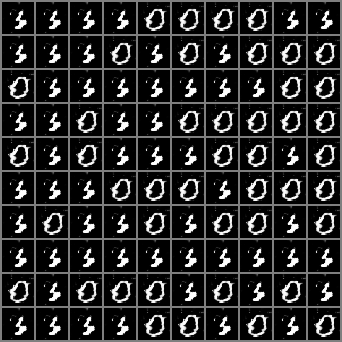

epoch: 5/10, batch: 110/600, G_loss: 3.3731188774108887, D_loss: (0.02911890298128128, 0.037920840084552765)
epoch: 5/10, batch: 120/600, G_loss: 3.057187080383301, D_loss: (0.04799937084317207, 0.051736246794462204)
epoch: 5/10, batch: 130/600, G_loss: 5.281951904296875, D_loss: (0.13300582766532898, 0.007764865644276142)
epoch: 5/10, batch: 140/600, G_loss: 10.167805671691895, D_loss: (0.32541215419769287, 0.03464522212743759)
epoch: 5/10, batch: 150/600, G_loss: 6.492106914520264, D_loss: (0.047262873500585556, 0.0033200529869645834)
epoch: 5/10, batch: 160/600, G_loss: 4.763183116912842, D_loss: (0.03724568709731102, 0.009463431313633919)
epoch: 5/10, batch: 170/600, G_loss: 1.9281585216522217, D_loss: (0.03971001133322716, 0.17770105600357056)
epoch: 5/10, batch: 180/600, G_loss: 1.7840582132339478, D_loss: (0.050312403589487076, 0.2209881991147995)
epoch: 5/10, batch: 190/600, G_loss: 7.704068183898926, D_loss: (0.029283316805958748, 0.03479877486824989)
epoch: 5/10, batch: 200/6

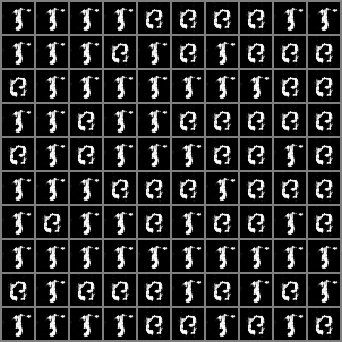

epoch: 5/10, batch: 210/600, G_loss: 7.429361343383789, D_loss: (0.012565621174871922, 0.3648238480091095)
epoch: 5/10, batch: 220/600, G_loss: 3.14998722076416, D_loss: (0.08088813722133636, 0.04634943976998329)
epoch: 5/10, batch: 230/600, G_loss: 3.5819897651672363, D_loss: (0.05064453184604645, 0.028581012040376663)
epoch: 5/10, batch: 240/600, G_loss: 3.8756396770477295, D_loss: (0.03514851629734039, 0.020974960178136826)
epoch: 5/10, batch: 250/600, G_loss: 2.91056752204895, D_loss: (0.024808157235383987, 0.05623776465654373)
epoch: 5/10, batch: 260/600, G_loss: 3.490504741668701, D_loss: (0.06777141243219376, 0.03311176970601082)
epoch: 5/10, batch: 270/600, G_loss: 3.3844618797302246, D_loss: (0.0178486667573452, 0.039330653846263885)
epoch: 5/10, batch: 280/600, G_loss: 2.541961669921875, D_loss: (0.057715293020009995, 0.09749697893857956)
epoch: 5/10, batch: 290/600, G_loss: 2.495753526687622, D_loss: (0.008739135228097439, 0.086493119597435)
epoch: 5/10, batch: 300/600, G_lo

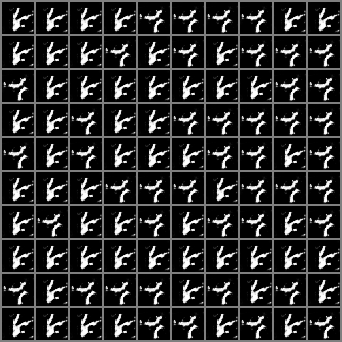

epoch: 5/10, batch: 310/600, G_loss: 3.9503469467163086, D_loss: (0.008771970868110657, 0.022679351270198822)
epoch: 5/10, batch: 320/600, G_loss: 3.43485164642334, D_loss: (0.04781481251120567, 0.03276500105857849)
epoch: 5/10, batch: 330/600, G_loss: 4.250262260437012, D_loss: (0.08814637362957001, 0.015388096682727337)
epoch: 5/10, batch: 340/600, G_loss: 4.364205837249756, D_loss: (0.01821395568549633, 0.020844509825110435)
epoch: 5/10, batch: 350/600, G_loss: 2.5027213096618652, D_loss: (0.03224879130721092, 0.08842913806438446)
epoch: 5/10, batch: 360/600, G_loss: 4.291755199432373, D_loss: (0.011846858076751232, 0.01435163989663124)
epoch: 5/10, batch: 370/600, G_loss: 3.6757335662841797, D_loss: (0.035692062228918076, 0.0339166522026062)
epoch: 5/10, batch: 380/600, G_loss: 2.1778769493103027, D_loss: (0.05579892173409462, 0.12028136104345322)
epoch: 5/10, batch: 390/600, G_loss: 5.974058628082275, D_loss: (1.0520990144868847e-05, 0.12606175243854523)
epoch: 5/10, batch: 400/60

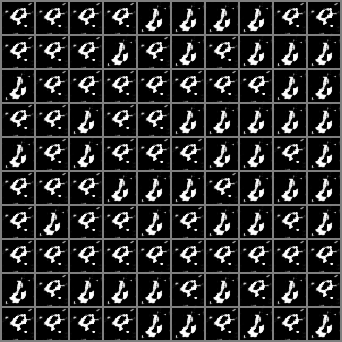

epoch: 5/10, batch: 410/600, G_loss: 3.2748446464538574, D_loss: (0.061452724039554596, 0.06895942986011505)
epoch: 5/10, batch: 420/600, G_loss: 1.8921016454696655, D_loss: (0.014022257179021835, 0.1662973165512085)
epoch: 5/10, batch: 430/600, G_loss: 3.1216869354248047, D_loss: (0.029797544702887535, 0.047052860260009766)
epoch: 5/10, batch: 440/600, G_loss: 3.6180503368377686, D_loss: (0.08749549090862274, 0.038645196706056595)
epoch: 5/10, batch: 450/600, G_loss: 3.581587791442871, D_loss: (0.020434584468603134, 0.029316945001482964)
epoch: 5/10, batch: 460/600, G_loss: 3.8307788372039795, D_loss: (0.011548543348908424, 0.02195047214627266)
epoch: 5/10, batch: 470/600, G_loss: 3.1816492080688477, D_loss: (0.027801835909485817, 0.04510205239057541)
epoch: 5/10, batch: 480/600, G_loss: 3.4712588787078857, D_loss: (0.019011450931429863, 0.03162067383527756)
epoch: 5/10, batch: 490/600, G_loss: 3.451306104660034, D_loss: (0.02601482719182968, 0.03283792734146118)
epoch: 5/10, batch: 5

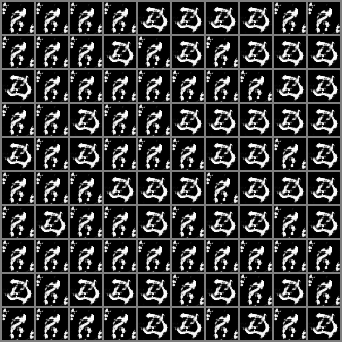

epoch: 5/10, batch: 510/600, G_loss: 3.7675728797912598, D_loss: (0.01742038130760193, 0.03424842283129692)
epoch: 5/10, batch: 520/600, G_loss: 4.858004570007324, D_loss: (0.11779346317052841, 0.017754236236214638)
epoch: 5/10, batch: 530/600, G_loss: 10.976848602294922, D_loss: (0.12401346117258072, 0.011623376980423927)
epoch: 5/10, batch: 540/600, G_loss: 7.142161846160889, D_loss: (0.08718834817409515, 0.002274317666888237)
epoch: 5/10, batch: 550/600, G_loss: 3.5864429473876953, D_loss: (0.09720325469970703, 0.030266620218753815)
epoch: 5/10, batch: 560/600, G_loss: 3.5903377532958984, D_loss: (0.014894727617502213, 0.02803368866443634)
epoch: 5/10, batch: 570/600, G_loss: 3.5120155811309814, D_loss: (0.07135853916406631, 0.030729202553629875)
epoch: 5/10, batch: 580/600, G_loss: 3.7851173877716064, D_loss: (0.04191960394382477, 0.0236579030752182)
epoch: 5/10, batch: 590/600, G_loss: 2.892702579498291, D_loss: (0.07170668244361877, 0.05766526609659195)
epoch: 6/10, batch: 0/600,

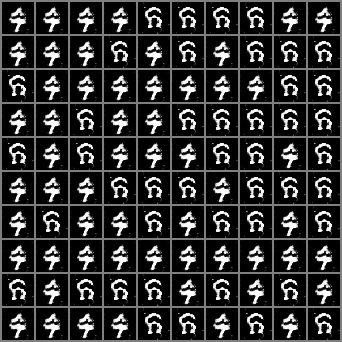

epoch: 6/10, batch: 10/600, G_loss: 3.5587987899780273, D_loss: (0.04555303230881691, 0.029801949858665466)
epoch: 6/10, batch: 20/600, G_loss: 3.7970328330993652, D_loss: (0.014498177915811539, 0.023580925539135933)
epoch: 6/10, batch: 30/600, G_loss: 3.2155628204345703, D_loss: (0.05191817879676819, 0.04199748486280441)
epoch: 6/10, batch: 40/600, G_loss: 4.323793411254883, D_loss: (0.005691812839359045, 0.01344401016831398)
epoch: 6/10, batch: 50/600, G_loss: 4.129858016967773, D_loss: (0.034462399780750275, 0.01632668450474739)
epoch: 6/10, batch: 60/600, G_loss: 3.5709075927734375, D_loss: (0.04560345783829689, 0.028542282059788704)
epoch: 6/10, batch: 70/600, G_loss: 4.296026706695557, D_loss: (0.038302358239889145, 0.013804305344820023)
epoch: 6/10, batch: 80/600, G_loss: 3.449385166168213, D_loss: (0.037571340799331665, 0.03243505582213402)
epoch: 6/10, batch: 90/600, G_loss: 6.47537899017334, D_loss: (0.031178073957562447, 0.030003823339939117)
epoch: 6/10, batch: 100/600, G_l

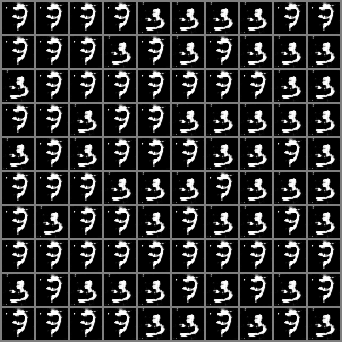

epoch: 6/10, batch: 110/600, G_loss: 4.967993259429932, D_loss: (0.014519520103931427, 0.007510627619922161)
epoch: 6/10, batch: 120/600, G_loss: 2.5340070724487305, D_loss: (0.022040339186787605, 0.08343258500099182)
epoch: 6/10, batch: 130/600, G_loss: 3.485830307006836, D_loss: (0.12038072943687439, 0.031123442575335503)
epoch: 6/10, batch: 140/600, G_loss: 4.223354816436768, D_loss: (0.031407833099365234, 0.015248872339725494)
epoch: 6/10, batch: 150/600, G_loss: 4.180031776428223, D_loss: (0.07696909457445145, 0.01553900633007288)
epoch: 6/10, batch: 160/600, G_loss: 4.278546333312988, D_loss: (0.032894980162382126, 0.017934368923306465)
epoch: 6/10, batch: 170/600, G_loss: 4.257440090179443, D_loss: (0.03495212644338608, 0.014290389604866505)
epoch: 6/10, batch: 180/600, G_loss: 3.4832193851470947, D_loss: (0.05218406766653061, 0.03443494439125061)
epoch: 6/10, batch: 190/600, G_loss: 2.766352891921997, D_loss: (0.0050574601627886295, 0.06502334773540497)
epoch: 6/10, batch: 200/

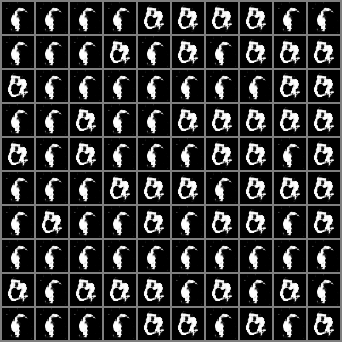

epoch: 6/10, batch: 210/600, G_loss: 5.014447212219238, D_loss: (0.013779508881270885, 0.02997528947889805)
epoch: 6/10, batch: 220/600, G_loss: 10.469169616699219, D_loss: (0.05732913315296173, 0.00692317821085453)
epoch: 6/10, batch: 230/600, G_loss: 11.51046371459961, D_loss: (0.0011268042726442218, 0.0021222857758402824)
epoch: 6/10, batch: 240/600, G_loss: 2.801283359527588, D_loss: (0.0246831513941288, 0.06630557775497437)
epoch: 6/10, batch: 250/600, G_loss: 2.8659543991088867, D_loss: (0.07267511636018753, 0.059654828161001205)
epoch: 6/10, batch: 260/600, G_loss: 3.043846368789673, D_loss: (0.04429906979203224, 0.04917656257748604)
epoch: 6/10, batch: 270/600, G_loss: 2.499723434448242, D_loss: (0.08451319485902786, 0.08607800304889679)
epoch: 6/10, batch: 280/600, G_loss: 3.569641351699829, D_loss: (0.17312143743038177, 0.03208738937973976)
epoch: 6/10, batch: 290/600, G_loss: 3.3252036571502686, D_loss: (0.03541175276041031, 0.036880768835544586)
epoch: 6/10, batch: 300/600,

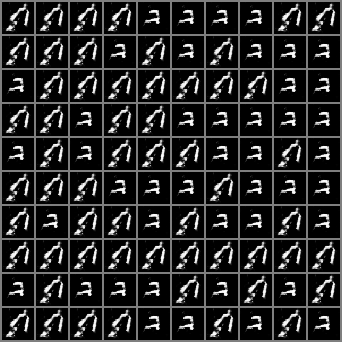

epoch: 6/10, batch: 310/600, G_loss: 3.3310155868530273, D_loss: (0.03788077086210251, 0.03858768567442894)
epoch: 6/10, batch: 320/600, G_loss: 4.125784397125244, D_loss: (0.025118373334407806, 0.016637757420539856)
epoch: 6/10, batch: 330/600, G_loss: 3.1710641384124756, D_loss: (0.026929223909974098, 0.04810557886958122)
epoch: 6/10, batch: 340/600, G_loss: 3.8424692153930664, D_loss: (0.008998585864901543, 0.0227087140083313)
epoch: 6/10, batch: 350/600, G_loss: 4.265652179718018, D_loss: (0.010400286875665188, 0.014329629950225353)
epoch: 6/10, batch: 360/600, G_loss: 4.139965057373047, D_loss: (0.0144142284989357, 0.01608307659626007)
epoch: 6/10, batch: 370/600, G_loss: 3.471142053604126, D_loss: (0.007611232344061136, 0.03313491493463516)
epoch: 6/10, batch: 380/600, G_loss: 2.226269483566284, D_loss: (0.033100660890340805, 0.135089710354805)
epoch: 6/10, batch: 390/600, G_loss: 5.167929172515869, D_loss: (0.16468030214309692, 0.005809750407934189)
epoch: 6/10, batch: 400/600, 

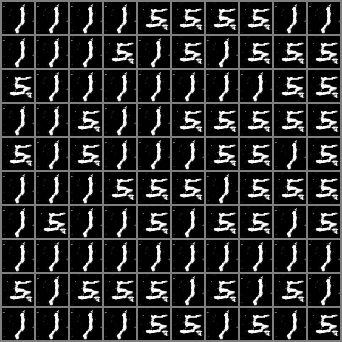

epoch: 6/10, batch: 410/600, G_loss: 3.5108487606048584, D_loss: (0.021811049431562424, 0.034843362867832184)
epoch: 6/10, batch: 420/600, G_loss: 3.174765110015869, D_loss: (0.038177818059921265, 0.04416175186634064)
epoch: 6/10, batch: 430/600, G_loss: 3.348431348800659, D_loss: (0.01906554400920868, 0.03791235759854317)
epoch: 6/10, batch: 440/600, G_loss: 4.181415557861328, D_loss: (0.028451649472117424, 0.016178015619516373)
epoch: 6/10, batch: 450/600, G_loss: 4.550743103027344, D_loss: (0.04417221248149872, 0.016886884346604347)
epoch: 6/10, batch: 460/600, G_loss: 5.717833042144775, D_loss: (0.2019156962633133, 0.003301355056464672)
epoch: 6/10, batch: 470/600, G_loss: 7.456638813018799, D_loss: (0.10982292145490646, 0.00061388174071908)
epoch: 6/10, batch: 480/600, G_loss: 4.520570278167725, D_loss: (0.039009857922792435, 0.01219912525266409)
epoch: 6/10, batch: 490/600, G_loss: 4.689598560333252, D_loss: (0.05174730718135834, 0.010231046937406063)
epoch: 6/10, batch: 500/600,

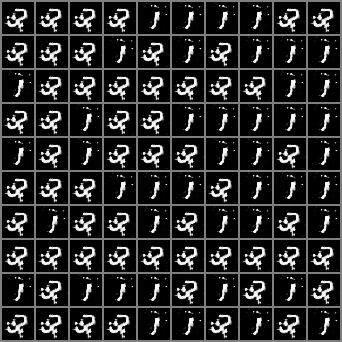

epoch: 6/10, batch: 510/600, G_loss: 2.429842472076416, D_loss: (0.013645673170685768, 0.09244074672460556)
epoch: 6/10, batch: 520/600, G_loss: 4.14865779876709, D_loss: (0.01662716455757618, 0.019733645021915436)
epoch: 6/10, batch: 530/600, G_loss: 4.272904872894287, D_loss: (0.018546629697084427, 0.014804110862314701)
epoch: 6/10, batch: 540/600, G_loss: 4.793588638305664, D_loss: (0.15072739124298096, 0.00834945123642683)
epoch: 6/10, batch: 550/600, G_loss: 3.6799557209014893, D_loss: (0.010246328078210354, 0.025564245879650116)
epoch: 6/10, batch: 560/600, G_loss: 4.366799831390381, D_loss: (0.03496995195746422, 0.01286208163946867)
epoch: 6/10, batch: 570/600, G_loss: 3.837939500808716, D_loss: (0.024303235113620758, 0.023243088275194168)
epoch: 6/10, batch: 580/600, G_loss: 5.108245849609375, D_loss: (0.04591427743434906, 0.021405663341283798)
epoch: 6/10, batch: 590/600, G_loss: 3.9010629653930664, D_loss: (0.010916483588516712, 0.021218424662947655)
epoch: 7/10, batch: 0/600

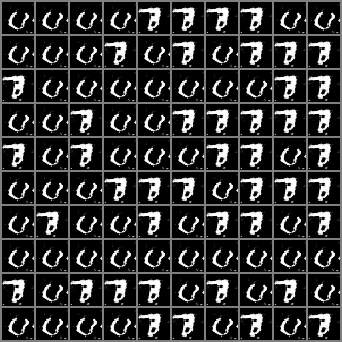

epoch: 7/10, batch: 10/600, G_loss: 3.210207462310791, D_loss: (0.0413840189576149, 0.04490042105317116)
epoch: 7/10, batch: 20/600, G_loss: 10.093374252319336, D_loss: (0.38772353529930115, 4.956349584972486e-05)
epoch: 7/10, batch: 30/600, G_loss: 3.9861886501312256, D_loss: (0.04727501794695854, 0.021198125556111336)
epoch: 7/10, batch: 40/600, G_loss: 3.71820068359375, D_loss: (0.018948642536997795, 0.025531940162181854)
epoch: 7/10, batch: 50/600, G_loss: 2.712855815887451, D_loss: (0.005724458023905754, 0.071834996342659)
epoch: 7/10, batch: 60/600, G_loss: 4.030663967132568, D_loss: (0.012123292312026024, 0.01826661080121994)
epoch: 7/10, batch: 70/600, G_loss: 3.173544406890869, D_loss: (0.01855580136179924, 0.04422205314040184)
epoch: 7/10, batch: 80/600, G_loss: 4.363123893737793, D_loss: (0.04890470579266548, 0.023602956905961037)
epoch: 7/10, batch: 90/600, G_loss: 4.588827610015869, D_loss: (0.04728172346949577, 0.011428123340010643)
epoch: 7/10, batch: 100/600, G_loss: 5.

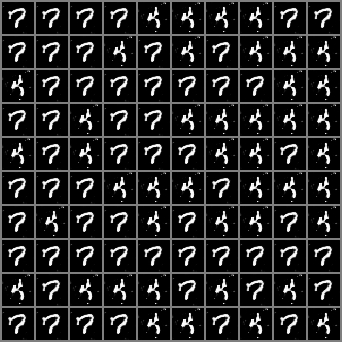

epoch: 7/10, batch: 110/600, G_loss: 4.542788028717041, D_loss: (0.015710776671767235, 0.011081780306994915)
epoch: 7/10, batch: 120/600, G_loss: 4.754547595977783, D_loss: (0.03887956961989403, 0.009540986269712448)
epoch: 7/10, batch: 130/600, G_loss: 4.2451605796813965, D_loss: (0.049158915877342224, 0.014778923243284225)
epoch: 7/10, batch: 140/600, G_loss: 5.071774959564209, D_loss: (0.008038129657506943, 0.00647004833444953)
epoch: 7/10, batch: 150/600, G_loss: 4.260034084320068, D_loss: (0.008495457470417023, 0.016850020736455917)
epoch: 7/10, batch: 160/600, G_loss: 6.3140153884887695, D_loss: (0.06865239888429642, 0.0018221130594611168)
epoch: 7/10, batch: 170/600, G_loss: 4.595343112945557, D_loss: (0.004834129475057125, 0.013264033943414688)
epoch: 7/10, batch: 180/600, G_loss: 5.31948709487915, D_loss: (0.015875231474637985, 0.004915701691061258)
epoch: 7/10, batch: 190/600, G_loss: 6.150640964508057, D_loss: (0.0998522937297821, 0.0022469174582511187)
epoch: 7/10, batch: 2

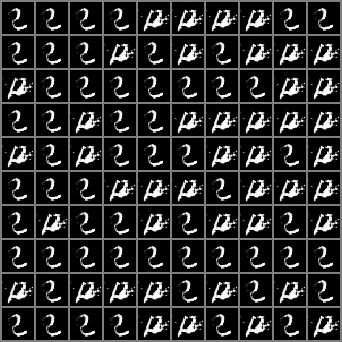

epoch: 7/10, batch: 210/600, G_loss: 3.8971283435821533, D_loss: (0.01600823365151882, 0.021147413179278374)
epoch: 7/10, batch: 220/600, G_loss: 4.407010078430176, D_loss: (0.004264371935278177, 0.04029249772429466)
epoch: 7/10, batch: 230/600, G_loss: 4.050653457641602, D_loss: (0.019283734261989594, 0.03048075921833515)
epoch: 7/10, batch: 240/600, G_loss: 3.630925178527832, D_loss: (0.029688794165849686, 0.028020808473229408)
epoch: 7/10, batch: 250/600, G_loss: 5.156929969787598, D_loss: (0.05181390419602394, 0.006315642036497593)
epoch: 7/10, batch: 260/600, G_loss: 12.71234130859375, D_loss: (0.03588101267814636, 0.10682709515094757)
epoch: 7/10, batch: 270/600, G_loss: 4.737457752227783, D_loss: (0.0752749890089035, 0.00917520746588707)
epoch: 7/10, batch: 280/600, G_loss: 3.7153730392456055, D_loss: (0.0627763569355011, 0.026687903329730034)
epoch: 7/10, batch: 290/600, G_loss: 3.034756660461426, D_loss: (0.026579584926366806, 0.3139612674713135)
epoch: 7/10, batch: 300/600, G

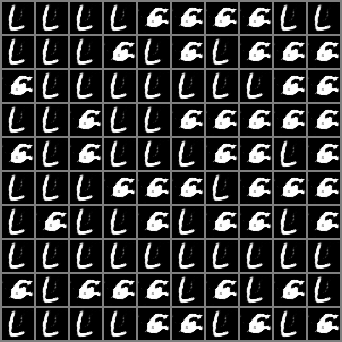

epoch: 7/10, batch: 310/600, G_loss: 6.118305683135986, D_loss: (0.033636804670095444, 0.010893234983086586)
epoch: 7/10, batch: 320/600, G_loss: 4.1992011070251465, D_loss: (0.17795349657535553, 0.02158995158970356)
epoch: 7/10, batch: 330/600, G_loss: 3.1296744346618652, D_loss: (0.034802161157131195, 0.06122878938913345)
epoch: 7/10, batch: 340/600, G_loss: 3.051353693008423, D_loss: (0.02622610330581665, 0.06118631362915039)
epoch: 7/10, batch: 350/600, G_loss: 2.786700963973999, D_loss: (0.0451020710170269, 0.07838863879442215)
epoch: 7/10, batch: 360/600, G_loss: 4.4620585441589355, D_loss: (0.008422248996794224, 0.011752932332456112)
epoch: 7/10, batch: 370/600, G_loss: 3.6046135425567627, D_loss: (0.02152935042977333, 0.030188780277967453)
epoch: 7/10, batch: 380/600, G_loss: 3.4323534965515137, D_loss: (0.16043667495250702, 0.040846940129995346)
epoch: 7/10, batch: 390/600, G_loss: 12.608179092407227, D_loss: (0.05198032036423683, 0.00017106834275182337)
epoch: 7/10, batch: 40

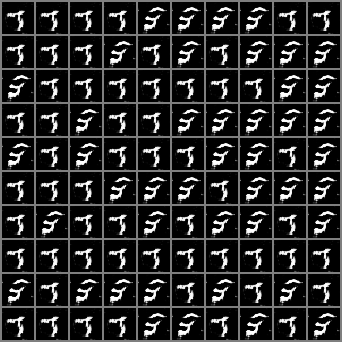

epoch: 7/10, batch: 410/600, G_loss: 7.284957408905029, D_loss: (0.025216417387127876, 0.0009603251237422228)
epoch: 7/10, batch: 420/600, G_loss: 3.6102840900421143, D_loss: (0.12819363176822662, 0.050589755177497864)
epoch: 7/10, batch: 430/600, G_loss: 7.876186370849609, D_loss: (0.011896198615431786, 0.0006892445962876081)
epoch: 7/10, batch: 440/600, G_loss: 16.293838500976562, D_loss: (0.1192883551120758, 5.918184797337744e-06)
epoch: 7/10, batch: 450/600, G_loss: 4.649291515350342, D_loss: (0.01785369962453842, 0.030889611691236496)
epoch: 7/10, batch: 460/600, G_loss: 2.584216594696045, D_loss: (0.02107136882841587, 0.08440780639648438)
epoch: 7/10, batch: 470/600, G_loss: 4.111715316772461, D_loss: (0.019186412915587425, 0.018150685355067253)
epoch: 7/10, batch: 480/600, G_loss: 3.921790361404419, D_loss: (0.01948598586022854, 0.02043195255100727)
epoch: 7/10, batch: 490/600, G_loss: 4.176668167114258, D_loss: (0.024303894490003586, 0.018598483875393867)
epoch: 7/10, batch: 50

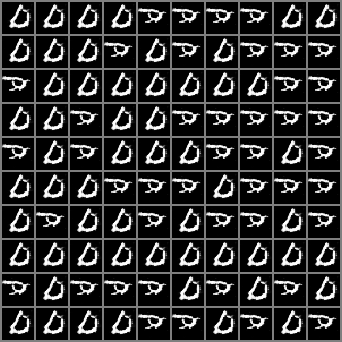

epoch: 7/10, batch: 510/600, G_loss: 3.910696506500244, D_loss: (0.07229543477296829, 0.02364548295736313)
epoch: 7/10, batch: 520/600, G_loss: 3.221177339553833, D_loss: (0.01911710947751999, 0.055269207805395126)
epoch: 7/10, batch: 530/600, G_loss: 2.9723236560821533, D_loss: (0.07877393066883087, 0.05494247376918793)
epoch: 7/10, batch: 540/600, G_loss: 3.7878329753875732, D_loss: (0.06007375195622444, 0.023101557046175003)
epoch: 7/10, batch: 550/600, G_loss: 3.5069198608398438, D_loss: (0.04099014401435852, 0.036233410239219666)
epoch: 7/10, batch: 560/600, G_loss: 3.2937636375427246, D_loss: (0.0274374857544899, 0.037967707961797714)
epoch: 7/10, batch: 570/600, G_loss: 3.7834062576293945, D_loss: (0.03330639377236366, 0.10224654525518417)
epoch: 7/10, batch: 580/600, G_loss: 8.713449478149414, D_loss: (0.3490224778652191, 0.0018235170282423496)
epoch: 7/10, batch: 590/600, G_loss: 5.02750301361084, D_loss: (0.006295167841017246, 0.029378658160567284)
epoch: 8/10, batch: 0/600, 

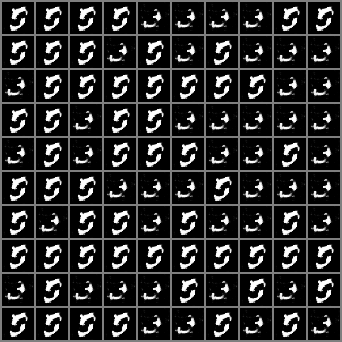

epoch: 8/10, batch: 10/600, G_loss: 3.582737445831299, D_loss: (0.08510804921388626, 0.029207834973931313)
epoch: 8/10, batch: 20/600, G_loss: 3.871683120727539, D_loss: (0.10859602689743042, 0.02235332876443863)
epoch: 8/10, batch: 30/600, G_loss: 3.7289867401123047, D_loss: (0.04669230058789253, 0.024328429251909256)
epoch: 8/10, batch: 40/600, G_loss: 3.6745355129241943, D_loss: (0.01872098632156849, 0.02571449987590313)
epoch: 8/10, batch: 50/600, G_loss: 5.122220516204834, D_loss: (0.055809784680604935, 0.035506751388311386)
epoch: 8/10, batch: 60/600, G_loss: 2.95658540725708, D_loss: (0.019815310835838318, 0.05900825932621956)
epoch: 8/10, batch: 70/600, G_loss: 4.91838264465332, D_loss: (0.058271124958992004, 0.007571235299110413)
epoch: 8/10, batch: 80/600, G_loss: 2.590196132659912, D_loss: (0.06192692741751671, 0.0783916637301445)
epoch: 8/10, batch: 90/600, G_loss: 5.017994403839111, D_loss: (0.016475513577461243, 0.06064232811331749)
epoch: 8/10, batch: 100/600, G_loss: 4.

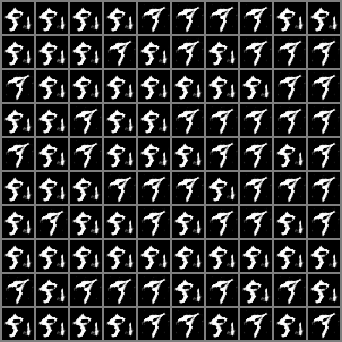

epoch: 8/10, batch: 110/600, G_loss: 3.22589111328125, D_loss: (0.03231042996048927, 0.04073934257030487)
epoch: 8/10, batch: 120/600, G_loss: 9.411218643188477, D_loss: (0.9259058237075806, 0.00012253255408722907)
epoch: 8/10, batch: 130/600, G_loss: 7.351564884185791, D_loss: (0.06726547330617905, 0.003224781481549144)
epoch: 8/10, batch: 140/600, G_loss: 4.546443939208984, D_loss: (0.03090510331094265, 0.014851998537778854)
epoch: 8/10, batch: 150/600, G_loss: 6.642209529876709, D_loss: (0.206920325756073, 0.006410738918930292)
epoch: 8/10, batch: 160/600, G_loss: 2.450576066970825, D_loss: (0.060038972645998, 0.13409429788589478)
epoch: 8/10, batch: 170/600, G_loss: 6.221743583679199, D_loss: (0.05044816434383392, 0.0034362152218818665)
epoch: 8/10, batch: 180/600, G_loss: 3.3998024463653564, D_loss: (0.010203317739069462, 0.035870373249053955)
epoch: 8/10, batch: 190/600, G_loss: 3.088996171951294, D_loss: (0.053453002125024796, 0.05252177268266678)
epoch: 8/10, batch: 200/600, G_

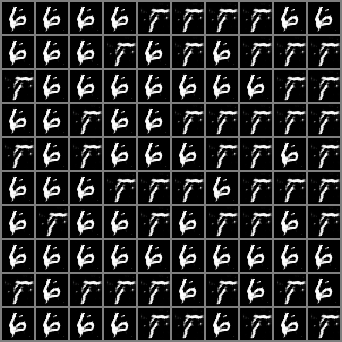

epoch: 8/10, batch: 210/600, G_loss: 4.1432061195373535, D_loss: (0.059231795370578766, 0.016241060569882393)
epoch: 8/10, batch: 220/600, G_loss: 3.9782445430755615, D_loss: (0.07929597795009613, 0.019854871556162834)
epoch: 8/10, batch: 230/600, G_loss: 2.7855539321899414, D_loss: (0.056147489696741104, 0.07776740193367004)
epoch: 8/10, batch: 240/600, G_loss: 7.909243583679199, D_loss: (0.0894206315279007, 0.0010004951618611813)
epoch: 8/10, batch: 250/600, G_loss: 7.832357406616211, D_loss: (0.4338911473751068, 0.0011831286828964949)
epoch: 8/10, batch: 260/600, G_loss: 4.312513828277588, D_loss: (0.08728872984647751, 0.014073138125240803)
epoch: 8/10, batch: 270/600, G_loss: 4.170988082885742, D_loss: (0.0394296869635582, 0.017204126343131065)
epoch: 8/10, batch: 280/600, G_loss: 10.240050315856934, D_loss: (0.01283801719546318, 0.017025327309966087)
epoch: 8/10, batch: 290/600, G_loss: 5.369263172149658, D_loss: (0.08555921912193298, 0.007701347582042217)
epoch: 8/10, batch: 300/

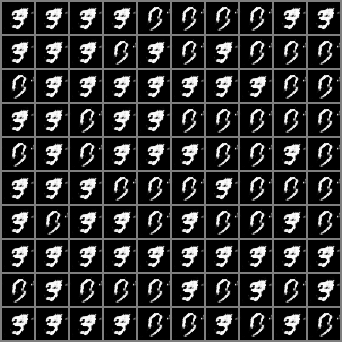

epoch: 8/10, batch: 310/600, G_loss: 5.166704177856445, D_loss: (0.010784512385725975, 0.005726741626858711)
epoch: 8/10, batch: 320/600, G_loss: 3.270674228668213, D_loss: (0.00278577022254467, 0.0438993014395237)
epoch: 8/10, batch: 330/600, G_loss: 2.7422616481781006, D_loss: (0.02398752234876156, 0.07865261286497116)
epoch: 8/10, batch: 340/600, G_loss: 3.915461540222168, D_loss: (0.01969628781080246, 0.02957048825919628)
epoch: 8/10, batch: 350/600, G_loss: 3.3292276859283447, D_loss: (0.04237690567970276, 0.03743356838822365)
epoch: 8/10, batch: 360/600, G_loss: 3.8625879287719727, D_loss: (0.03201454505324364, 0.022630147635936737)
epoch: 8/10, batch: 370/600, G_loss: 4.299196243286133, D_loss: (0.003965848591178656, 0.014660017564892769)
epoch: 8/10, batch: 380/600, G_loss: 3.0236401557922363, D_loss: (0.008067800663411617, 0.09347502887248993)
epoch: 8/10, batch: 390/600, G_loss: 4.35661506652832, D_loss: (0.026192523539066315, 0.014893259853124619)
epoch: 8/10, batch: 400/600

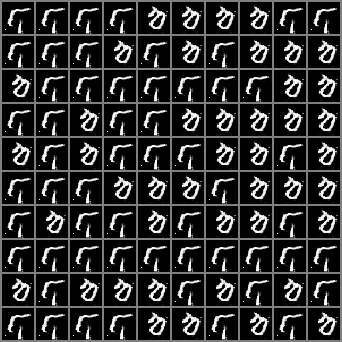

epoch: 8/10, batch: 410/600, G_loss: 3.959188461303711, D_loss: (0.019970057532191277, 0.019429439678788185)
epoch: 8/10, batch: 420/600, G_loss: 3.581982135772705, D_loss: (0.011119162663817406, 0.0290742889046669)
epoch: 8/10, batch: 430/600, G_loss: 3.9037280082702637, D_loss: (0.033539656549692154, 0.02160022221505642)
epoch: 8/10, batch: 440/600, G_loss: 2.924828290939331, D_loss: (0.012586398050189018, 0.057815954089164734)
epoch: 8/10, batch: 450/600, G_loss: 4.788417339324951, D_loss: (0.01080242544412613, 0.009970416314899921)
epoch: 8/10, batch: 460/600, G_loss: 15.034708023071289, D_loss: (0.27501457929611206, 3.1268684779206524e-06)
epoch: 8/10, batch: 470/600, G_loss: 4.194036960601807, D_loss: (0.05469708517193794, 0.015526603907346725)
epoch: 8/10, batch: 480/600, G_loss: 2.865030288696289, D_loss: (0.03474664315581322, 0.14026527106761932)
epoch: 8/10, batch: 490/600, G_loss: 12.735320091247559, D_loss: (0.1287088394165039, 3.8635839700873476e-06)
epoch: 8/10, batch: 50

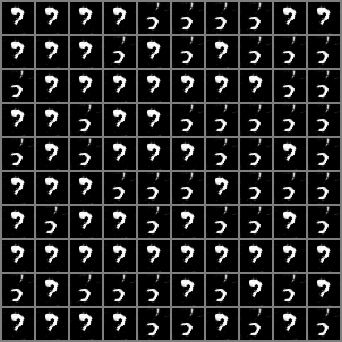

epoch: 8/10, batch: 510/600, G_loss: 3.618908643722534, D_loss: (0.02082449197769165, 0.03213077783584595)
epoch: 8/10, batch: 520/600, G_loss: 1.3600587844848633, D_loss: (0.030370883643627167, 0.2990272045135498)
epoch: 8/10, batch: 530/600, G_loss: 3.5807759761810303, D_loss: (0.02040550298988819, 0.02826062962412834)
epoch: 8/10, batch: 540/600, G_loss: 3.1160168647766113, D_loss: (0.007188914343714714, 0.06889726221561432)
epoch: 8/10, batch: 550/600, G_loss: 11.73373794555664, D_loss: (0.0059890164993703365, 0.0020096779335290194)
epoch: 8/10, batch: 560/600, G_loss: 3.6278116703033447, D_loss: (0.09579625725746155, 0.028457827866077423)
epoch: 8/10, batch: 570/600, G_loss: 3.260138511657715, D_loss: (0.182706817984581, 0.03917491063475609)
epoch: 8/10, batch: 580/600, G_loss: 3.0542571544647217, D_loss: (0.09440980106592178, 0.04837850481271744)
epoch: 8/10, batch: 590/600, G_loss: 3.331092119216919, D_loss: (0.17629358172416687, 0.03644919767975807)
epoch: 9/10, batch: 0/600, G

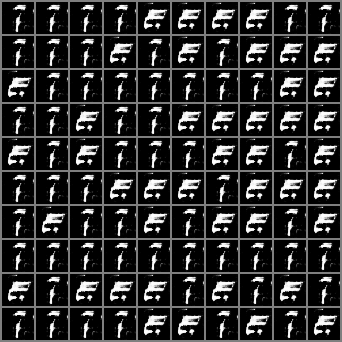

epoch: 9/10, batch: 10/600, G_loss: 3.1940805912017822, D_loss: (0.02913626655936241, 0.04692426696419716)
epoch: 9/10, batch: 20/600, G_loss: 4.555214881896973, D_loss: (0.0017062383703887463, 0.2993106245994568)
epoch: 9/10, batch: 30/600, G_loss: 5.83418083190918, D_loss: (0.007224647328257561, 0.010826395824551582)
epoch: 9/10, batch: 40/600, G_loss: 4.481110095977783, D_loss: (0.020232871174812317, 0.011699981987476349)
epoch: 9/10, batch: 50/600, G_loss: 4.367570400238037, D_loss: (0.06786790490150452, 0.019341878592967987)
epoch: 9/10, batch: 60/600, G_loss: 3.2199954986572266, D_loss: (0.16709506511688232, 0.28635022044181824)
epoch: 9/10, batch: 70/600, G_loss: 5.208096981048584, D_loss: (0.004853988066315651, 0.07734350115060806)
epoch: 9/10, batch: 80/600, G_loss: 4.432851791381836, D_loss: (0.07055775821208954, 0.012032082304358482)
epoch: 9/10, batch: 90/600, G_loss: 3.8014755249023438, D_loss: (0.01171562634408474, 0.022815944626927376)
epoch: 9/10, batch: 100/600, G_loss

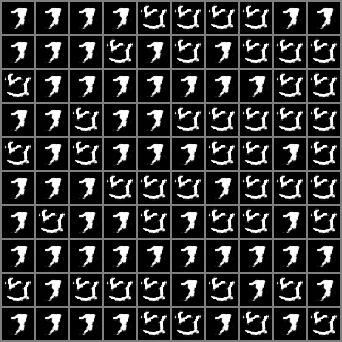

epoch: 9/10, batch: 110/600, G_loss: 3.989790916442871, D_loss: (0.00473681790754199, 0.020962567999958992)
epoch: 9/10, batch: 120/600, G_loss: 4.488088607788086, D_loss: (0.04418376088142395, 0.011670350097119808)
epoch: 9/10, batch: 130/600, G_loss: 4.075693130493164, D_loss: (0.0011952760396525264, 0.017249319702386856)
epoch: 9/10, batch: 140/600, G_loss: 6.196155548095703, D_loss: (0.0961892381310463, 0.004404993262141943)
epoch: 9/10, batch: 150/600, G_loss: 3.609551429748535, D_loss: (0.017894437536597252, 0.0280416589230299)
epoch: 9/10, batch: 160/600, G_loss: 4.665461540222168, D_loss: (0.0016092532314360142, 0.009467036463320255)
epoch: 9/10, batch: 170/600, G_loss: 4.219701766967773, D_loss: (0.007586846128106117, 0.016862189397215843)
epoch: 9/10, batch: 180/600, G_loss: 4.009744644165039, D_loss: (0.025995902717113495, 0.019726527854800224)
epoch: 9/10, batch: 190/600, G_loss: 6.485750675201416, D_loss: (0.031172284856438637, 0.0017158400733023882)
epoch: 9/10, batch: 20

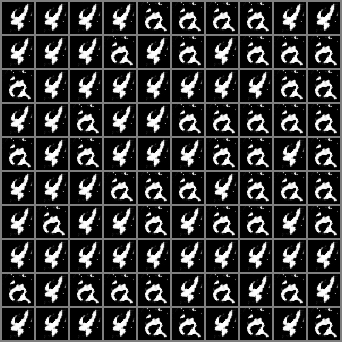

epoch: 9/10, batch: 210/600, G_loss: 3.8142616748809814, D_loss: (0.026319505646824837, 0.02233239822089672)
epoch: 9/10, batch: 220/600, G_loss: 4.094203472137451, D_loss: (0.028792597353458405, 0.01984133943915367)
epoch: 9/10, batch: 230/600, G_loss: 3.1749935150146484, D_loss: (0.024503637105226517, 0.04971860349178314)
epoch: 9/10, batch: 240/600, G_loss: 2.9570956230163574, D_loss: (0.0777151882648468, 0.05348009243607521)
epoch: 9/10, batch: 250/600, G_loss: 6.722116470336914, D_loss: (0.0794353112578392, 0.005902817472815514)
epoch: 9/10, batch: 260/600, G_loss: 10.284222602844238, D_loss: (0.0024443436414003372, 8.909258031053469e-05)
epoch: 9/10, batch: 270/600, G_loss: 4.040350437164307, D_loss: (0.029990077018737793, 0.017763573676347733)
epoch: 9/10, batch: 280/600, G_loss: 4.024667263031006, D_loss: (0.016539908945560455, 0.02139914594590664)
epoch: 9/10, batch: 290/600, G_loss: 3.8416199684143066, D_loss: (0.04440462961792946, 0.021810393780469894)
epoch: 9/10, batch: 30

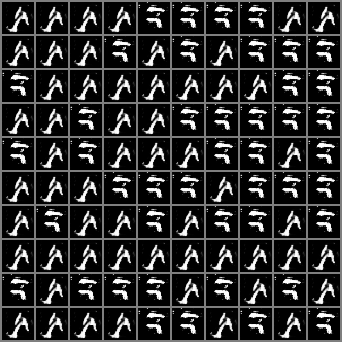

epoch: 9/10, batch: 310/600, G_loss: 3.9086649417877197, D_loss: (0.013871720060706139, 0.02075088955461979)
epoch: 9/10, batch: 320/600, G_loss: 4.184686183929443, D_loss: (0.044391848146915436, 0.01736706867814064)
epoch: 9/10, batch: 330/600, G_loss: 22.308263778686523, D_loss: (0.21787546575069427, 0.0)
epoch: 9/10, batch: 340/600, G_loss: 6.317285537719727, D_loss: (0.07133381068706512, 0.011992014944553375)
epoch: 9/10, batch: 350/600, G_loss: 8.16528034210205, D_loss: (0.1890103667974472, 0.02096400037407875)
epoch: 9/10, batch: 360/600, G_loss: 5.081049919128418, D_loss: (0.04751205071806908, 0.008083620108664036)
epoch: 9/10, batch: 370/600, G_loss: 3.4012956619262695, D_loss: (0.02897992916405201, 0.03789259120821953)
epoch: 9/10, batch: 380/600, G_loss: 4.312496185302734, D_loss: (0.011717241257429123, 0.013789490796625614)
epoch: 9/10, batch: 390/600, G_loss: 3.8392016887664795, D_loss: (0.014835433103144169, 0.021761445328593254)
epoch: 9/10, batch: 400/600, G_loss: 2.5658

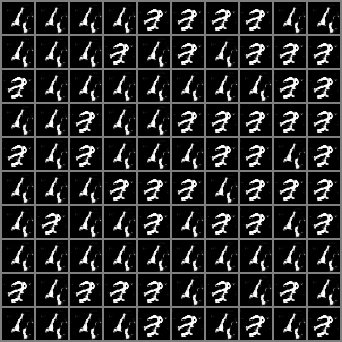

epoch: 9/10, batch: 410/600, G_loss: 4.0087714195251465, D_loss: (0.0407526008784771, 0.01960032805800438)
epoch: 9/10, batch: 420/600, G_loss: 4.015160083770752, D_loss: (0.03768360987305641, 0.01829295977950096)
epoch: 9/10, batch: 430/600, G_loss: 4.151744842529297, D_loss: (0.03632153198122978, 0.01607457920908928)
epoch: 9/10, batch: 440/600, G_loss: 3.941061496734619, D_loss: (0.04438026249408722, 0.019841870293021202)
epoch: 9/10, batch: 450/600, G_loss: 4.178353309631348, D_loss: (0.006361081730574369, 0.015490737743675709)
epoch: 9/10, batch: 460/600, G_loss: 4.552527904510498, D_loss: (0.04753946140408516, 0.011291942559182644)
epoch: 9/10, batch: 470/600, G_loss: 4.0578789710998535, D_loss: (0.03243669494986534, 0.0183191429823637)
epoch: 9/10, batch: 480/600, G_loss: 5.220590114593506, D_loss: (0.11900197714567184, 0.006405319552868605)
epoch: 9/10, batch: 490/600, G_loss: 4.249361991882324, D_loss: (0.014976851642131805, 0.014511793851852417)
epoch: 9/10, batch: 500/600, G

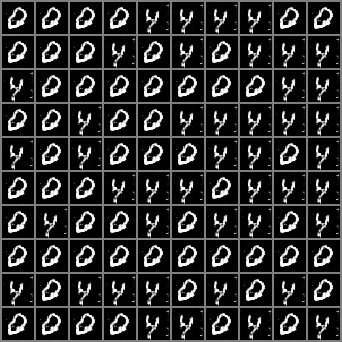

epoch: 9/10, batch: 510/600, G_loss: 4.719552993774414, D_loss: (0.07875872403383255, 0.019263237714767456)
epoch: 9/10, batch: 520/600, G_loss: 4.96926736831665, D_loss: (0.012925231829285622, 0.008754241280257702)
epoch: 9/10, batch: 530/600, G_loss: 5.007521152496338, D_loss: (0.0010993268806487322, 0.008758721873164177)
epoch: 9/10, batch: 540/600, G_loss: 3.0436456203460693, D_loss: (0.028935153037309647, 0.05273715406656265)
epoch: 9/10, batch: 550/600, G_loss: 2.626422166824341, D_loss: (0.06262996047735214, 0.07779638469219208)
epoch: 9/10, batch: 560/600, G_loss: 4.233329772949219, D_loss: (0.025707166641950607, 0.01588675193488598)
epoch: 9/10, batch: 570/600, G_loss: 3.9905667304992676, D_loss: (0.0460914708673954, 0.020004024729132652)
epoch: 9/10, batch: 580/600, G_loss: 3.1949374675750732, D_loss: (0.0299726203083992, 0.042301811277866364)
epoch: 9/10, batch: 590/600, G_loss: 3.7186903953552246, D_loss: (0.006716015283018351, 0.029604384675621986)


In [0]:
for epoch in range(num_epochs):
    for n_batch, (real_samples, labels) in enumerate(data_loader):
        
        real_samples = Variable(real_samples).cuda()
        labels1 = Variable(labels).cuda()

        loss_g, loss_d = model.step_optimization(real_samples, labels1)
        
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(data_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        if (n_batch) % 100 == 0:
            val_fake_samples,_ = model.generate_samples(num_val_samples)
            display_batch_images(val_fake_samples)